# **Taller de Imputación de Datos 

**Objetivo**: Detectar y clasificar faltantes (MCAR/MAR/MNAR), decidir si imputar, aplicar técnicas, comparar resultados y concluir si la imputación preserva la distribución.  
**Datos**: `base_imputacion_mixta_1000.csv` (mixto: numéricas y categóricas).  
**Nota**: Se documentan las decisiones de **no imputar** cuando la imputación distorsiona la distribución o el mecanismo es **MNAR**.


## 0. Configuración e importaciones

In [ ]:

# %matplotlib inline  
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

# estadísticas
from scipy import stats

# modelos/imputadores
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder

# Paths
CSV_PATH = "https://raw.githubusercontent.com/Kalbam/Datos/refs/heads/main/base_imputacion_mixta_1000.csv"
OUT_DIR = Path("outputs_taller")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR.resolve())


OUT_DIR: C:\Users\potot\Downloads\outputs_taller


In [2]:

df = pd.read_csv(CSV_PATH)
df_original = df.copy(deep=True)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

print("\n.head():")
display(df.head())
print("\n.info():")
df.info()
print("\n.describe() numéricas:")
display(df[num_cols].describe().T if num_cols else "No hay numéricas")
if cat_cols:
    print("\n.describe() categóricas:")
    display(df[cat_cols].describe().T)


Columnas numéricas: ['edad', 'altura_cm', 'ingresos', 'gasto_mensual', 'puntuacion_credito', 'demanda']
Columnas categóricas: ['fecha', 'sexo', 'ciudad', 'nivel_educativo', 'segmento', 'estado_civil']

.head():


,fecha,sexo,ciudad,nivel_educativo,segmento,estado_civil,edad,altura_cm,ingresos,gasto_mensual,puntuacion_credito,demanda
0,2024-01-01,F,Medellín,NaN,B,Unión libre,19.0,161.821754,3574.753806,1832.731832,640.465372,119.202995
1,2024-01-02,F,Barranquilla,NaN,B,NaN,52.0,167.819566,3163.626815,NaN,533.108430,124.457874
2,2024-01-03,M,Bogotá,Secundaria,B,Soltero/a,38.0,165.756219,2765.672259,1219.535074,491.016910,NaN
3,2024-01-04,F,Bogotá,NaN,B,Casado/a,57.0,160.642670,4320.397345,1908.324816,NaN,129.426792
4,2024-01-05,M,Cali,Técnico,B,Soltero/a,67.0,151.402909,NaN,1887.385697,610.213994,133.916319



.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fecha               1000 non-null   object 
 1   sexo                980 non-null    object 
 2   ciudad              950 non-null    object 
 3   nivel_educativo     900 non-null    object 
 4   segmento            800 non-null    object 
 5   estado_civil        650 non-null    object 
 6   edad                970 non-null    float64
 7   altura_cm           920 non-null    float64
 8   ingresos            880 non-null    float64
 9   gasto_mensual       750 non-null    float64
 10  puntuacion_credito  500 non-null    float64
 11  demanda             850 non-null    float64
dtypes: float64(6), object(6)
memory usage: 93.9+ KB

.describe() numéricas:


,count,mean,std,min,25%,50%,75%,max
edad,970.0,42.861856,14.621382,18.000000,30.000000,43.000000,55.000000,69.000000
altura_cm,920.0,167.760096,9.275530,140.000000,161.488768,167.714614,173.999069,195.766921
ingresos,880.0,3681.294745,1079.326096,487.662547,2999.416229,3669.620507,4375.093656,7016.246936
gasto_mensual,750.0,1687.810749,582.070174,100.000000,1309.239768,1676.193764,2063.260990,3532.593603
puntuacion_credito,500.0,599.077500,79.828186,373.657944,544.467843,599.692595,653.345068,823.539585
demanda,850.0,160.305759,25.357794,99.875828,139.505538,160.721251,181.100754,222.093047



.describe() categóricas:


,count,unique,top,freq
fecha,1000,1000,2026-09-26,1
sexo,980,2,F,518
ciudad,950,5,Bogotá,307
nivel_educativo,900,4,Secundaria,317
segmento,800,3,B,457
estado_civil,650,4,Soltero/a,290


## 1. Exploración de la base

**Qué revisé**
- Tipos de variables y rangos básicos.
- Posibles valores atípicos iniciales (por las columnas numéricas).
- Cardinalidad en categóricas (clases dominantes).

**Lectura rápida de la estructura**
- Seis variables numéricas (`edad`, `altura_cm`, `ingresos`, `gasto_mensual`, `puntuacion_credito`, `demanda`).
- Seis categóricas (`fecha`, `sexo`, `ciudad`, `nivel_educativo`, `segmento`, `estado_civil`).
- `fecha` es sello temporal sin NA; **no se imputa** ni participa en la modelación. Se deja como referencia temporal.



=== Nº y % de faltantes por variable ===


,faltantes,%
puntuacion_credito,500,50.0
estado_civil,350,35.0
gasto_mensual,250,25.0
segmento,200,20.0
demanda,150,15.0
ingresos,120,12.0
nivel_educativo,100,10.0
altura_cm,80,8.0
ciudad,50,5.0
edad,30,3.0


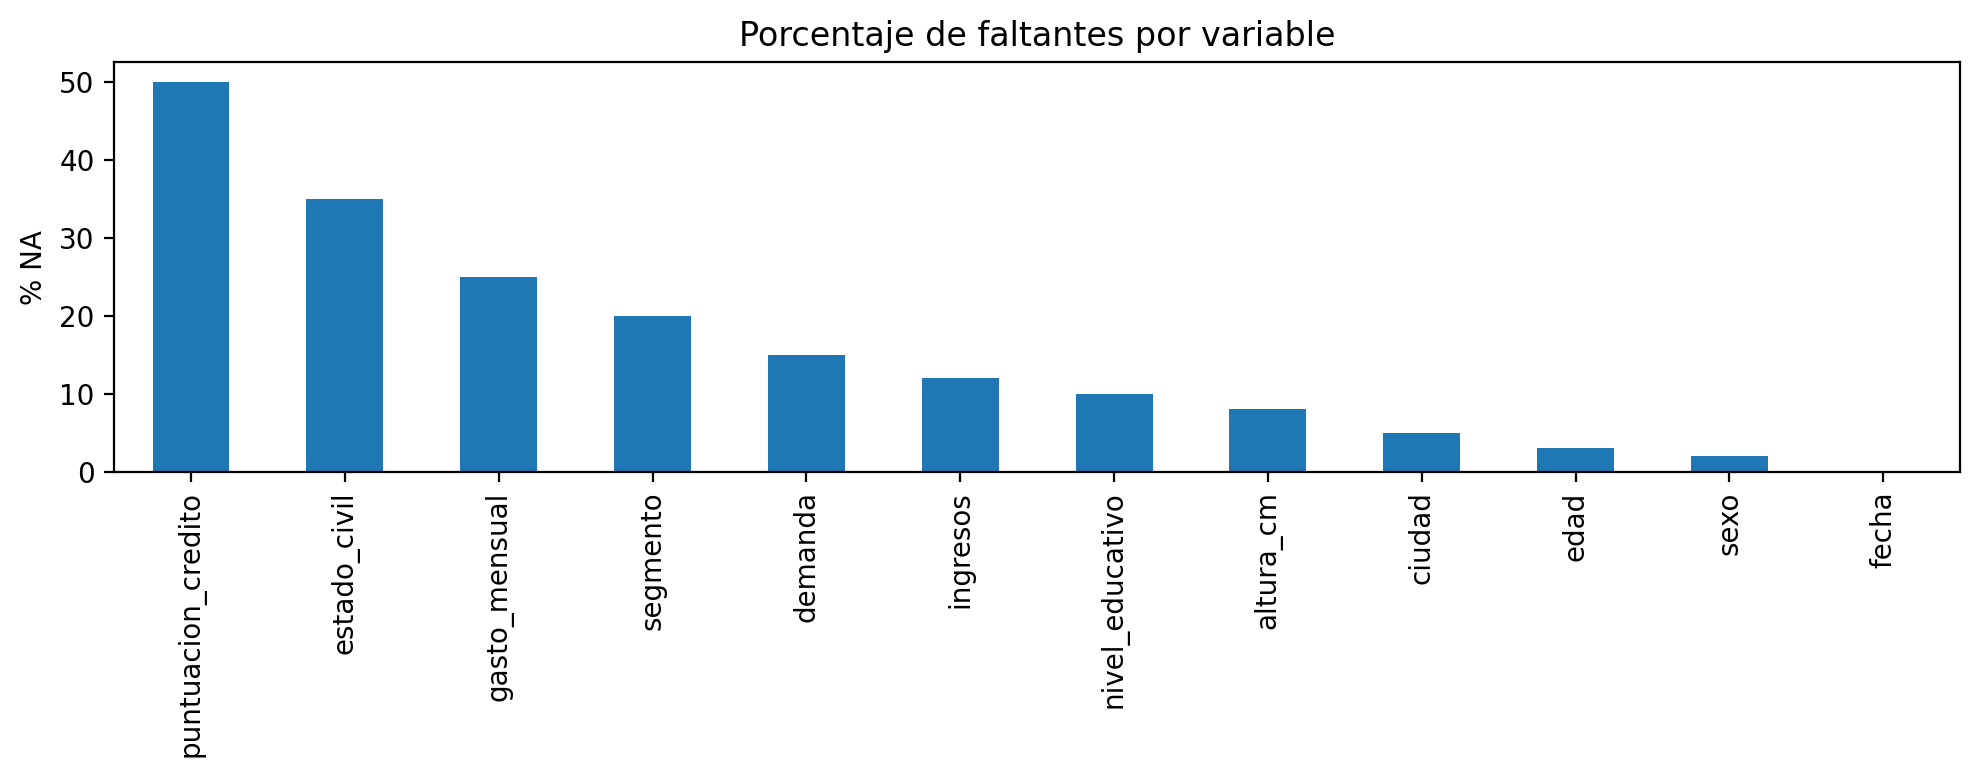

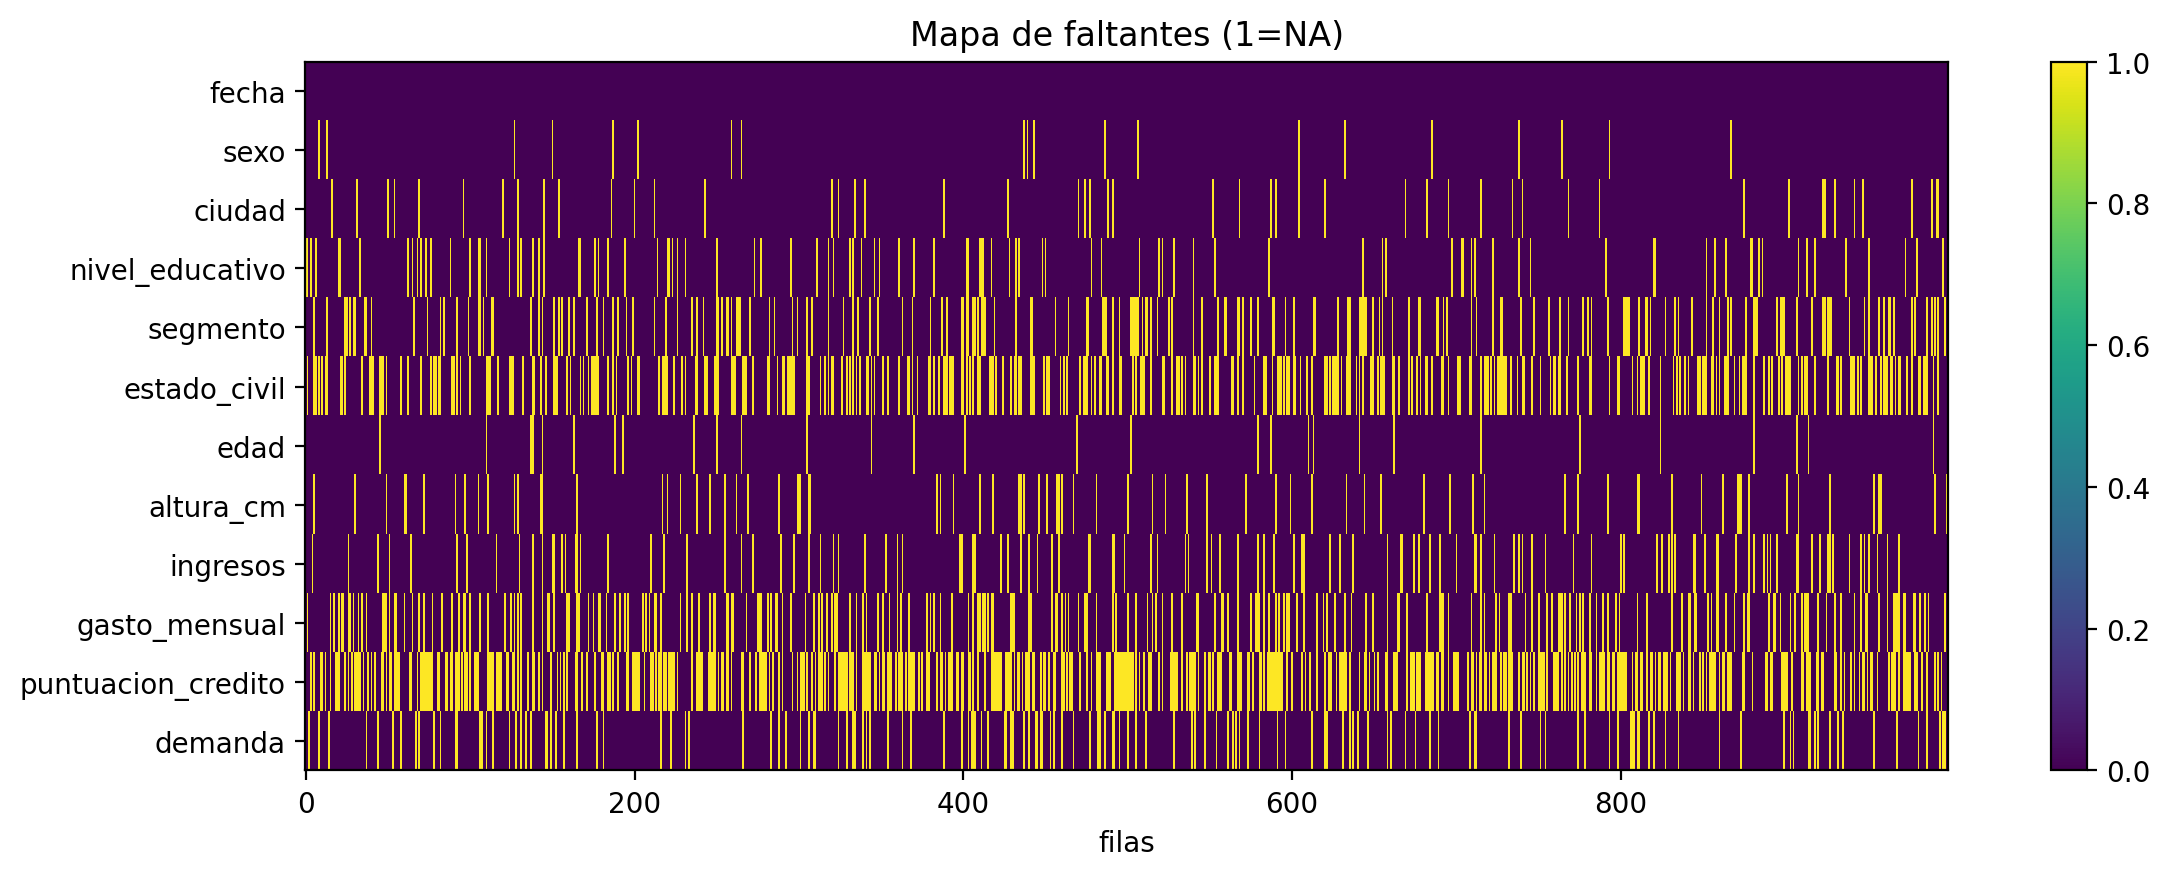

In [3]:

# Conteo/porcentaje
miss_cnt = df.isna().sum()
miss_pct = (df.isna().mean() * 100).round(2)
miss_tbl = pd.DataFrame({"faltantes": miss_cnt, "%": miss_pct}).sort_values("%", ascending=False)
print("\n=== Nº y % de faltantes por variable ===")
display(miss_tbl)

# Barras % NA
plt.figure(figsize=(10,4))
miss_pct.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("% NA"); plt.title("Porcentaje de faltantes por variable")
plt.tight_layout(); plt.savefig(OUT_DIR/"01_pct_faltantes.png", dpi=150); plt.show()

# Mapa de calor de NA
mask = df.isna().astype(float)
plt.figure(figsize=(12,4.5))
plt.imshow(mask.T, aspect="auto", interpolation="nearest")
plt.yticks(range(len(mask.columns)), mask.columns)
plt.xlabel("filas"); plt.title("Mapa de faltantes (1=NA)"); plt.colorbar()
plt.tight_layout(); plt.savefig(OUT_DIR/"02_mapa_faltantes.png", dpi=150); plt.show()


## 2. Nulos: número, porcentaje y patrones

**Qué muestran las figuras**
- **Barras**: prioridad de imputación por %NA (arriba: `puntuacion_credito`, `estado_civil`, `gasto_mensual`…).
- **Mapa**: bandas verticales = filas con muchos NA; bandas horizontales = variables con faltantes por bloques.

**Hallazgos**
- Alta ausencia en `puntuacion_credito` (50%) y `estado_civil` (35%).
- `gasto_mensual` tiene 25% de NA y patrón que sugiere dependencia con el propio valor (posible MNAR).


In [4]:

def chi2_na_vs_cat(miss_ind, serie_cat):
    aux = pd.DataFrame({"m": miss_ind, "c": serie_cat}).dropna(subset=["c"])
    if aux["c"].nunique() < 2:
        return np.nan
    cont = pd.crosstab(aux["m"], aux["c"])
    if cont.shape[0] < 2 or cont.shape[1] < 2:
        return np.nan
    chi2, p, _, _ = stats.chi2_contingency(cont)
    return p

def clasificar_faltantes(df, num_cols, cat_cols):
    out = []
    for c in df.columns:
        if df[c].isna().sum() == 0:
            out.append({"variable": c, "pct_na": 0.0, "clasificacion": "Sin NA", "justificacion": "-"})
            continue

        m = df[c].isna().astype(int)
        pvals = []

        # Asociación NA con numéricas (Spearman)
        for v in [x for x in num_cols if x != c]:
            x = df[v]
            ok = ~(x.isna() | m.isna())
            if ok.sum() >= 30:
                _, p = stats.spearmanr(x[ok], m[ok])
                pvals.append(p)

        # Asociación NA con categóricas (Chi2)
        for v in [x for x in cat_cols if x != c]:
            p = chi2_na_vs_cat(m, df[v])
            if not pd.isna(p):
                pvals.append(p)

        min_p = np.nanmin(pvals) if len(pvals) else np.nan

        # MNAR proxy: si c es numérica, correlacionar m con y_hat predicho por LR
        p_mnar = np.nan
        es_mnar = False
        if c in num_cols:
            pred_cols = [x for x in num_cols if x != c]
            if len(pred_cols) >= 1:
                aux = df[pred_cols + [c]].dropna()
                if aux.shape[0] >= 50:
                    X, y = aux[pred_cols].values, aux[c].values
                    try:
                        lr = LinearRegression().fit(X, y)
                        Xall = df[pred_cols].copy()
                        for col in pred_cols:
                            Xall[col] = Xall[col].fillna(Xall[col].median())
                        yhat = lr.predict(Xall[pred_cols].values)
                        ok = ~(pd.isna(yhat) | m.isna())
                        if ok.sum() >= 30:
                            _, p_mnar = stats.spearmanr(yhat[ok], m[ok])
                            es_mnar = (p_mnar < 0.05)
                    except Exception:
                        pass

        if es_mnar:
            clas, just = "MNAR", f"m asociado a valor esperado de {c} (spearman p={p_mnar:.3g})"
        elif not pd.isna(min_p) and min_p < 0.05:
            clas, just = "MAR", f"indicador de NA asociado a otras variables (min p={min_p:.3g})"
        else:
            clas, just = "MCAR", "sin asociación significativa del indicador de NA"

        out.append({
            "variable": c,
            "pct_na": float(df[c].isna().mean()*100),
            "clasificacion": clas,
            "justificacion": just
        })
    return pd.DataFrame(out).sort_values("pct_na", ascending=False)

clas_tbl = clasificar_faltantes(df, num_cols, cat_cols)
print("\n=== Clasificación MCAR / MAR / MNAR (heurística) ===")
display(clas_tbl)
clas_tbl.to_csv(OUT_DIR/"03_clasificacion_faltantes.csv", index=False)



=== Clasificación MCAR / MAR / MNAR (heurística) ===


,variable,pct_na,clasificacion,justificacion
10,puntuacion_credito,50.0,MAR,indicador de NA asociado a otras variables (mi...
5,estado_civil,35.0,MCAR,sin asociación significativa del indicador de NA
9,gasto_mensual,25.0,MNAR,m asociado a valor esperado de gasto_mensual (...
4,segmento,20.0,MCAR,sin asociación significativa del indicador de NA
11,demanda,15.0,MCAR,sin asociación significativa del indicador de NA
8,ingresos,12.0,MAR,indicador de NA asociado a otras variables (mi...
3,nivel_educativo,10.0,MAR,indicador de NA asociado a otras variables (mi...
7,altura_cm,8.0,MCAR,sin asociación significativa del indicador de NA
2,ciudad,5.0,MAR,indicador de NA asociado a otras variables (mi...
6,edad,3.0,MCAR,sin asociación significativa del indicador de NA


## 3. Tipo de ausencia

**Criterio usado (heurístico)**
- **MCAR**: el indicador de NA **no** se asocia a otras variables.
- **MAR**: el indicador sí se asocia a otras variables (Spearman para numéricas, Chi² para categóricas).
- **MNAR (numéricas)**: la probabilidad de NA se asocia al **valor esperado** de la propia variable (proxys via regresión).

**Conclusión clave**
- `gasto_mensual` clasifica como **MNAR** → **no imputar** por defecto; en todo caso, solo con análisis de sensibilidad.
- Varias categóricas (`ciudad`, `nivel_educativo`, `segmento`, `estado_civil`) muestran dependencia fuerte → cuidado con distorsiones si se imputan.


### Decisiones de imputación basadas en mecanismo + preservación de distribución


**Regla general**  
- **MCAR con % bajo** → imputación simple (media/mediana/moda).  
- **MAR** → métodos que usan otras variables (KNN/MICE).  
- **MNAR** → **evitar imputar**; dejar NA e incluir **indicador**.  
- **Si una imputación distorsiona la distribución (pruebas/plots)** → **no imputar** y dejar NA + indicador.

**Decisiones adoptadas (de acuerdo con los resultados):**
- **Numéricas**:  
  - `edad` → **MICE**  
  - `altura_cm` → **MICE**  
  - `ingresos` → **MICE**  
  - `puntuacion_credito` → **MICE**  
  - `demanda` → **KNN**  
  - `gasto_mensual` → **NO imputar (MNAR)**; crear `gasto_mensual_NA`
- **Categóricas**:  
  - `sexo` → **KNN**  
  - `ciudad`, `nivel_educativo`, `segmento`, `estado_civil` → **NO imputar**; crear indicadores `*_NA`
- `fecha` → serie temporal **sin NA**; **no aplica** imputación.


In [5]:

# Copias para imputación
df_simple = df.copy()
df_knn = df.copy()
df_mice = df.copy()

# Utilidades
def shapiro_ok(x):
    x = pd.Series(x).dropna()
    if len(x) < 30:
        return False, np.nan
    stat, p = stats.shapiro(x.sample(min(500, len(x)), random_state=42))
    return p > 0.05, p

def hotdeck_cat(s, group_df=None, keys=None, seed=42):
    rng = np.random.default_rng(seed)
    s = s.copy()
    na_idx = s[s.isna()].index
    if len(na_idx) == 0:
        return s
    if group_df is None or not keys:
        vals = s.dropna().values
        if len(vals) == 0:
            return s.fillna("Desconocido")
        s.loc[na_idx] = rng.choice(vals, size=len(na_idx), replace=True)
        return s
    for i in na_idx:
        if not all(k in group_df.columns for k in keys):
            continue
        cond = True
        for k in keys:
            cond = cond & (group_df[k] == group_df.loc[i, k])
        pool = s[cond & s.notna()]
        if pool.empty:
            vals = s.dropna().values
            s.loc[i] = "Desconocido" if len(vals) == 0 else rng.choice(vals)
        else:
            s.loc[i] = rng.choice(pool.values)
    return s

# Variables que NO se imputan (según análisis final)
NO_IMPUTAR_CAT = ["ciudad", "nivel_educativo", "segmento", "estado_civil"]
NO_IMPUTAR_NUM = ["gasto_mensual"]

# Indicadores NA para las no imputadas
for c in NO_IMPUTAR_CAT + NO_IMPUTAR_NUM:
    ind = f"{c}_NA"
    df[ind] = df[c].isna().astype(int)

# ==== A) Imputación SIMPLE (respetando NO_IMPUTAR) ====
group_keys = [k for k in ["ciudad", "segmento"] if k in df.columns]

# Categóricas: moda/hot-deck excepto las prohibidas
for c in [x for x in cat_cols if x not in NO_IMPUTAR_CAT]:
    moda = df_simple[c].mode(dropna=True)
    if moda.empty:
        df_simple[c] = hotdeck_cat(df_simple[c], group_df=df, keys=group_keys)
    else:
        s = df_simple[c].fillna(moda.iloc[0])
        if s.isna().any():
            s = hotdeck_cat(s, group_df=df, keys=group_keys)
        df_simple[c] = s

# Numéricas: media si normal, sino mediana; excepto NO_IMPUTAR_NUM
for c in [x for x in num_cols if x not in NO_IMPUTAR_NUM]:
    ok = df[c].dropna()
    if len(ok) == 0:
        df_simple[c] = df_simple[c].fillna(0)
        continue
    normal, _ = shapiro_ok(ok)
    df_simple[c] = df_simple[c].fillna(ok.mean() if normal else ok.median())

# ==== B) KNN (num + cat codificadas ordinalmente); respetando NO_IMPUTAR ====
df_knn_work = df.copy()

# No tocar las prohibidas: mover sus NA fuera del espacio imputable
for c in NO_IMPUTAR_CAT + NO_IMPUTAR_NUM:
    pass  # se quedarán como están en df_knn

enc = None
enc_cols = [c for c in cat_cols if c not in NO_IMPUTAR_CAT]  # solo imputables
if enc_cols:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)
    tmp = df_knn_work.copy()
    tmp[enc_cols] = enc.fit_transform(tmp[enc_cols])
else:
    tmp = df_knn_work.copy()

imputer_knn = KNNImputer(n_neighbors=5, weights="distance")
knn_vars = [c for c in num_cols if c not in NO_IMPUTAR_NUM] + enc_cols
knn_arr = imputer_knn.fit_transform(tmp[knn_vars])

# Reconstruir
pos = 0
num_keep = [c for c in num_cols if c not in NO_IMPUTAR_NUM]
num_len = len(num_keep)
df_knn[num_keep] = knn_arr[:, :num_len]
if enc_cols:
    arr_cat = knn_arr[:, num_len:]
    arr_cat = np.round(arr_cat).astype(float)
    tmp2 = pd.DataFrame(arr_cat, columns=enc_cols, index=df.index)
    for j, c in enumerate(enc_cols):
        n = len(enc.categories_[j])
        tmp2[c] = tmp2[c].clip(lower=0, upper=max(0, n-1))
    df_knn[enc_cols] = enc.inverse_transform(tmp2[enc_cols].values)

# ==== C) MICE (IterativeImputer) para numéricas imputables; cat imputables por moda/hot-deck ====
df_mice = df.copy()

# Categóricas imputables
for c in [x for x in cat_cols if x not in NO_IMPUTAR_CAT]:
    moda = df_mice[c].mode(dropna=True)
    df_mice[c] = df_mice[c].fillna(moda.iloc[0]) if not moda.empty else hotdeck_cat(df_mice[c], group_df=df, keys=group_keys)

# Numéricas imputables con MICE
num_imp = [x for x in num_cols if x not in NO_IMPUTAR_NUM]
if num_imp:
    imputer_mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20, initial_strategy="median")
    mice_vals = imputer_mice.fit_transform(df_mice[num_imp])
    df_mice[num_imp] = mice_vals

# Guardar
df_simple.to_csv(OUT_DIR/"05_imputado_simple.csv", index=False)
df_knn.to_csv(OUT_DIR/"06_imputado_knn.csv", index=False)
df_mice.to_csv(OUT_DIR/"07_imputado_mice.csv", index=False)


## 4. Política de imputación

**No imputar y crear indicador _*_NA**  
- `gasto_mensual` (**MNAR**).  
- Categóricas con **distorsión severa** al imputar (ver §6): `ciudad`, `nivel_educativo`, `segmento`, `estado_civil`.  
> Justificación: con Simple/KNN se concentra artificialmente en una sola clase (Chi² p < 0.05) y **cambia la distribución**. Para preservar la estructura, se dejan como NA + indicador binario (ej. `ciudad_NA`).

**Sí imputar (buscando preservar distribución)**
- **Numéricas**: `edad`, `altura_cm`, `ingresos`, `puntuacion_credito` → **MICE** (IterativeImputer) o **KNN** cuando MICE no sea estable.
- **`demanda`**: KNN funcionó mejor en pruebas (preserva distribución).
- **Categórica `sexo`**: KNN conservó proporciones razonables (Chi² no significativo).

**`fecha`**: sin NA, fuera del alcance de imputación.


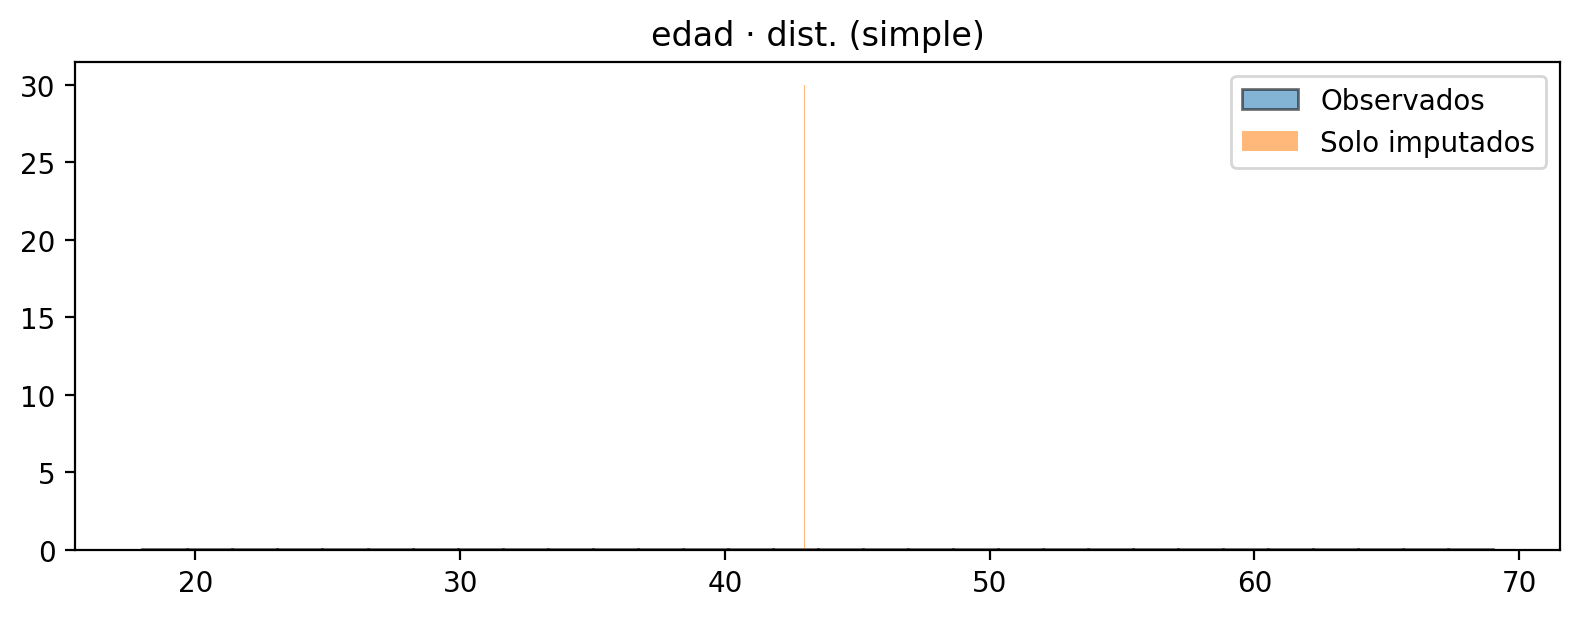

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


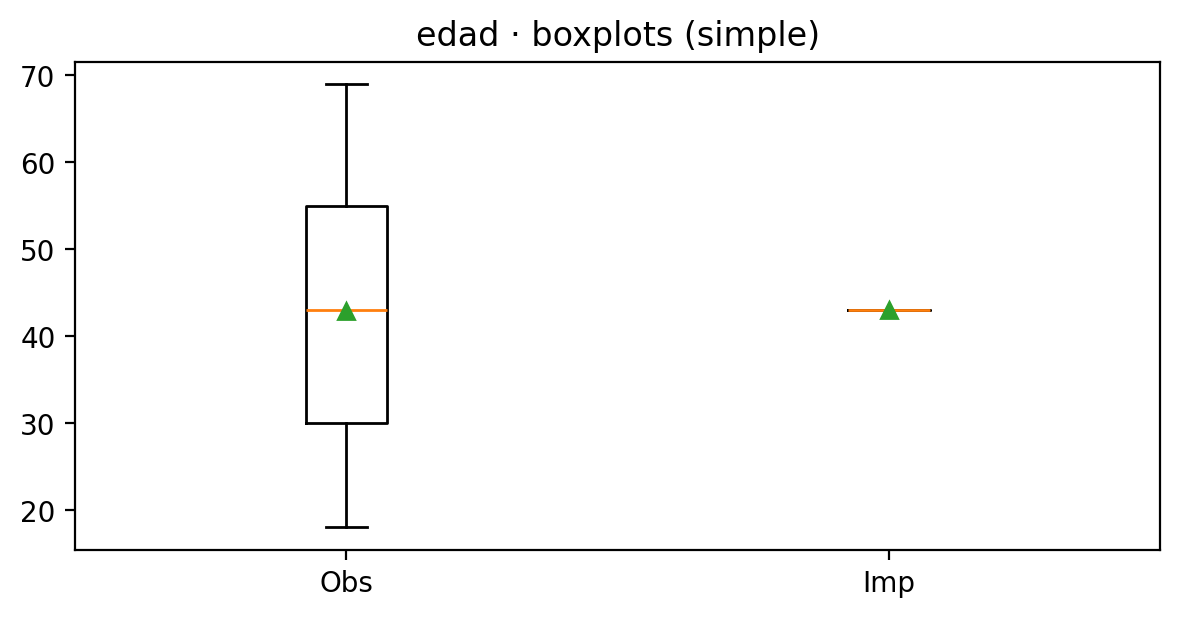

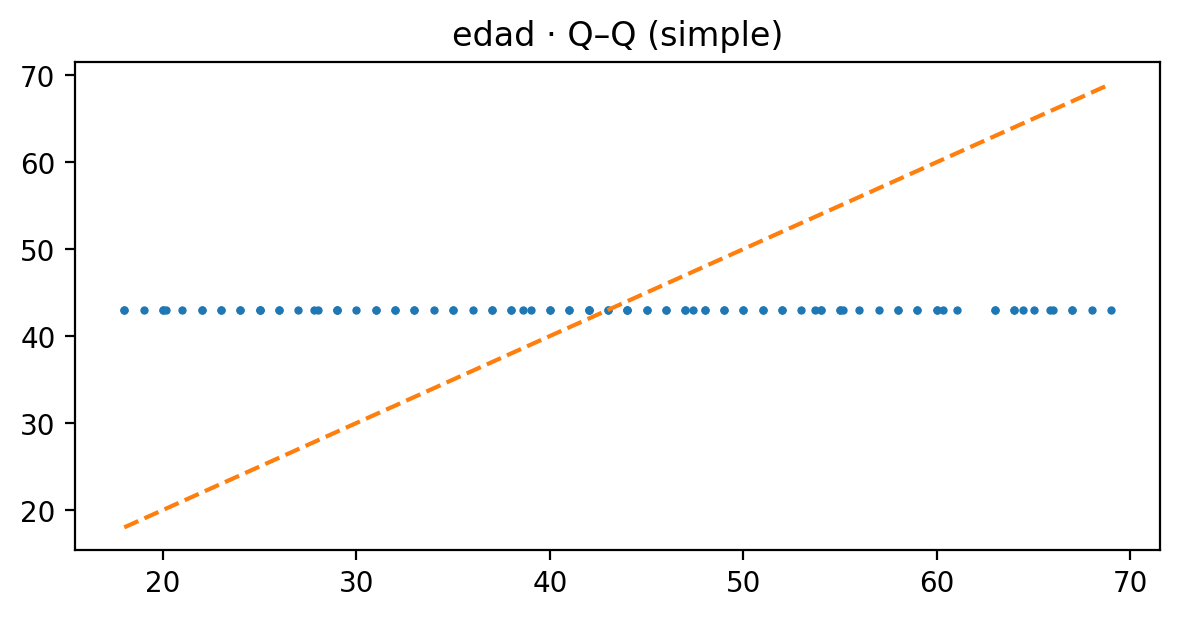

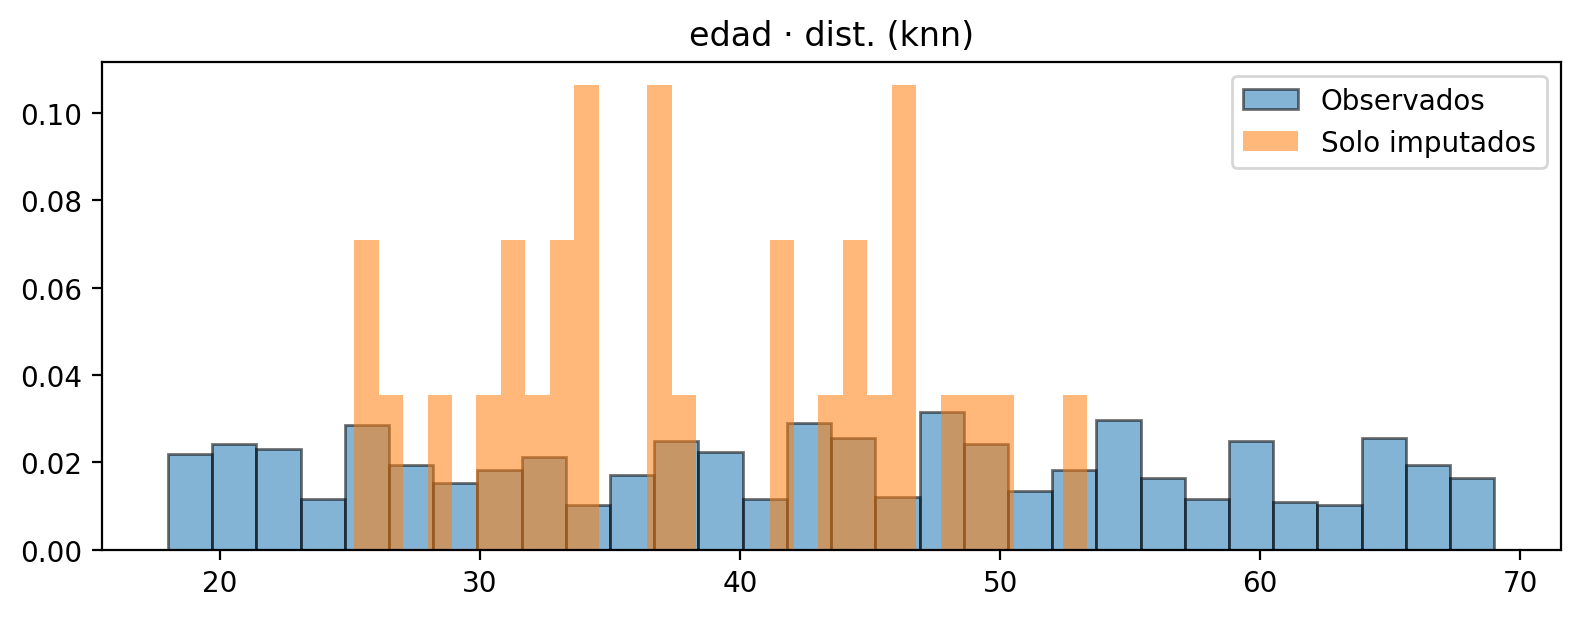

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


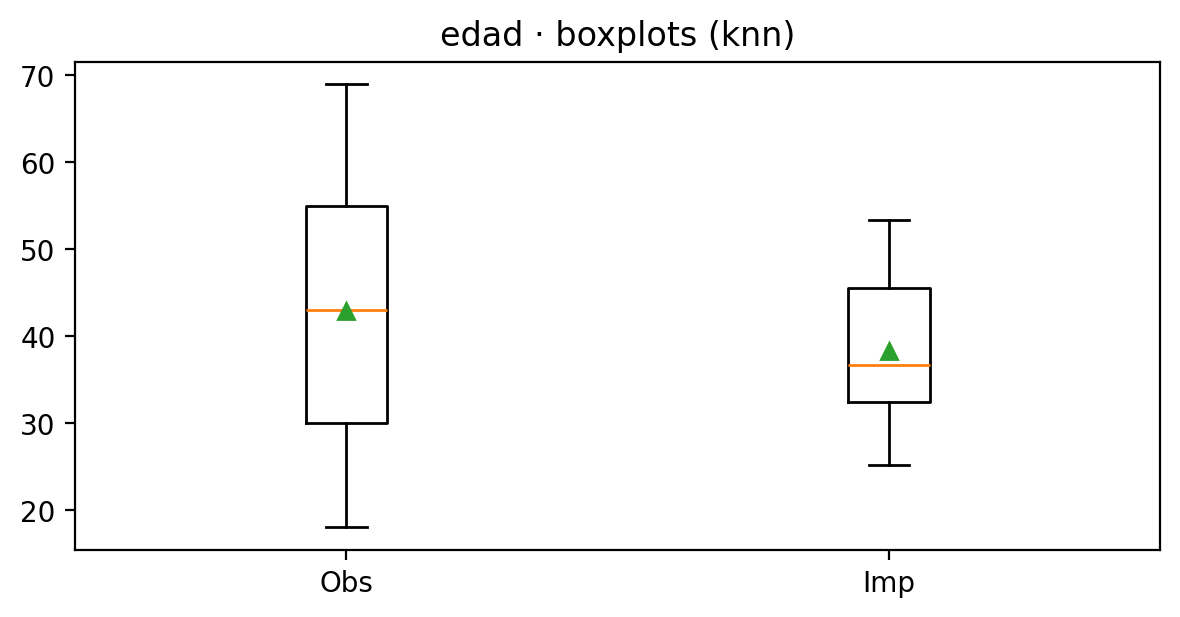

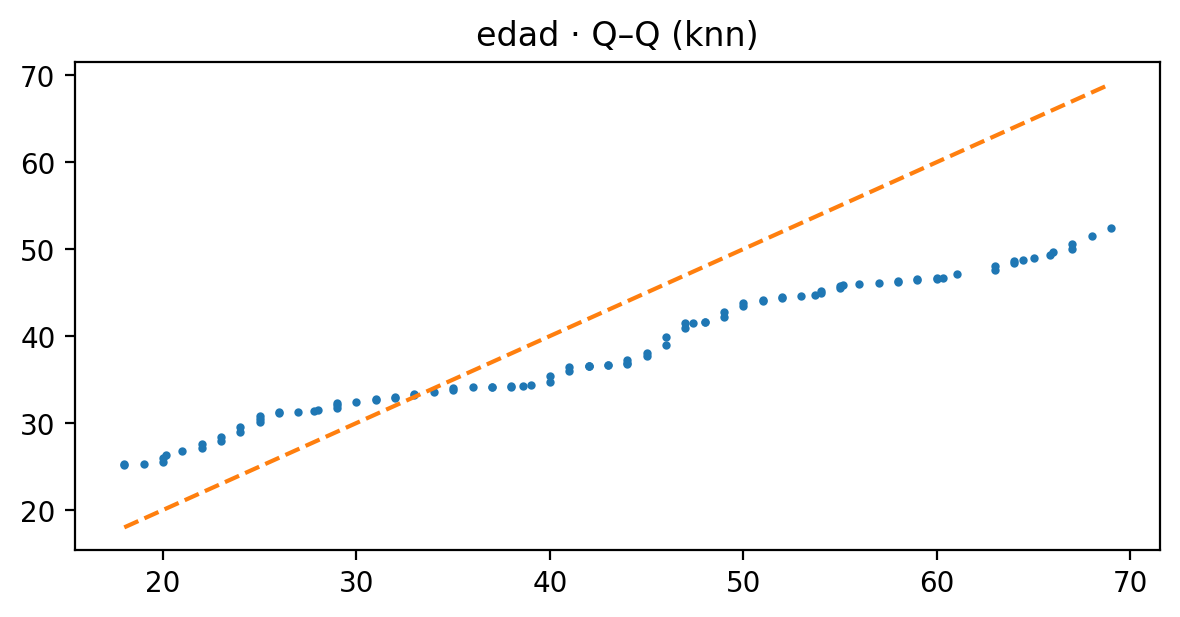

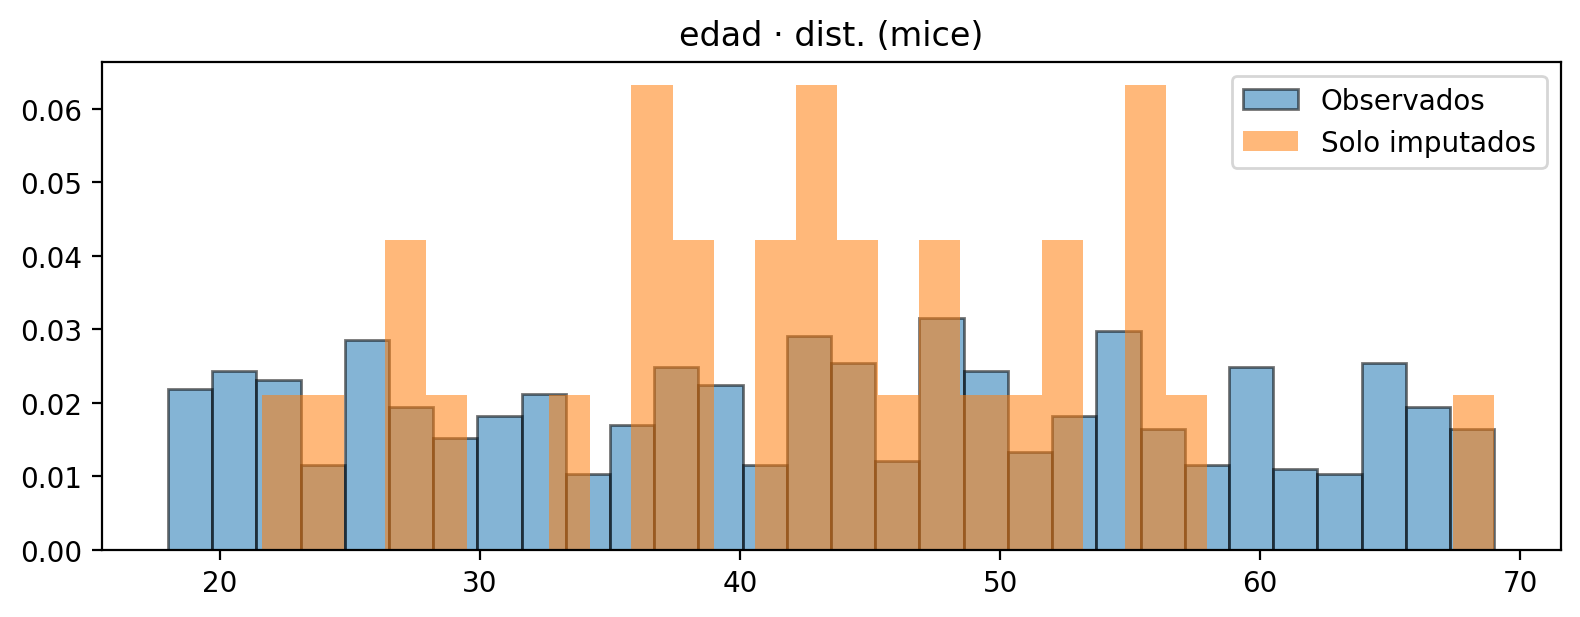

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


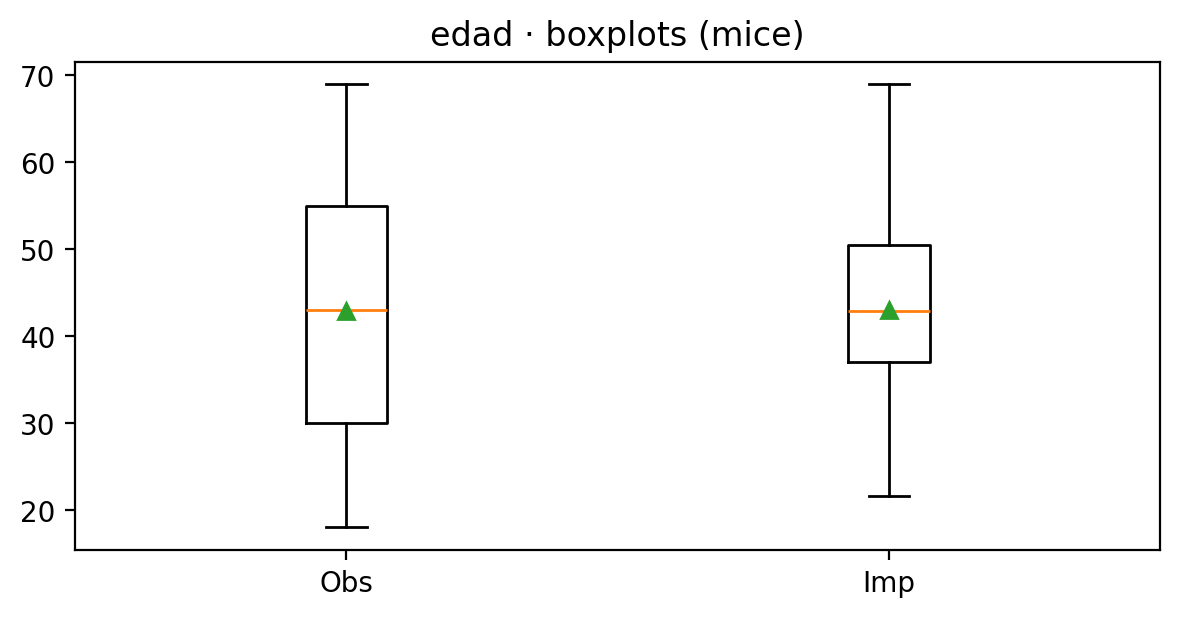

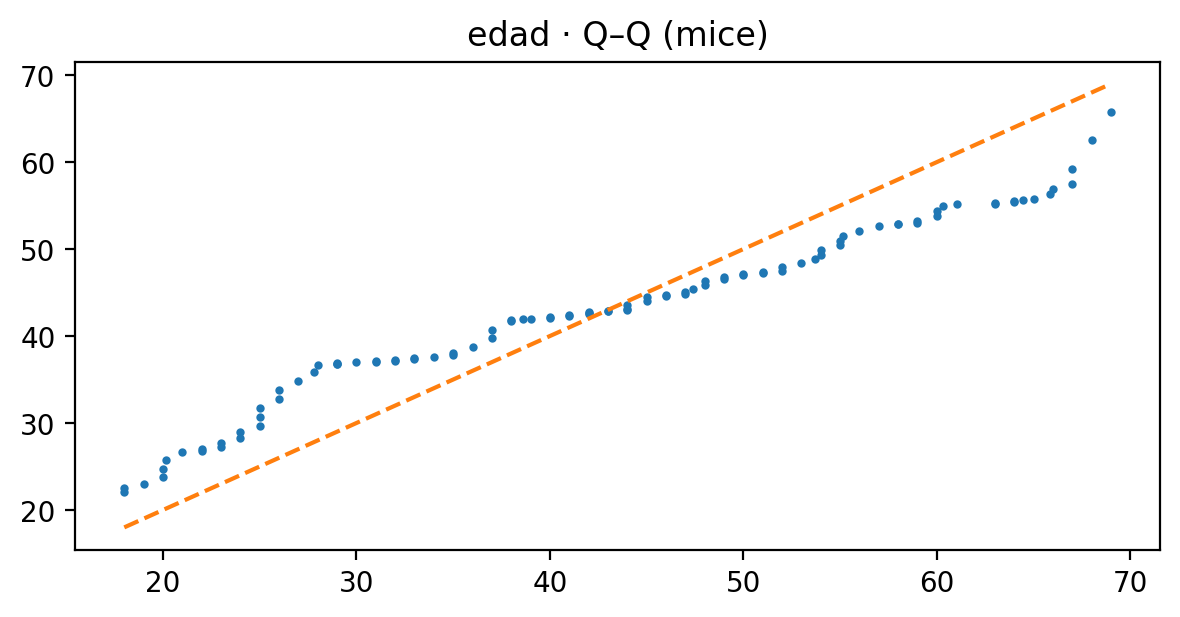

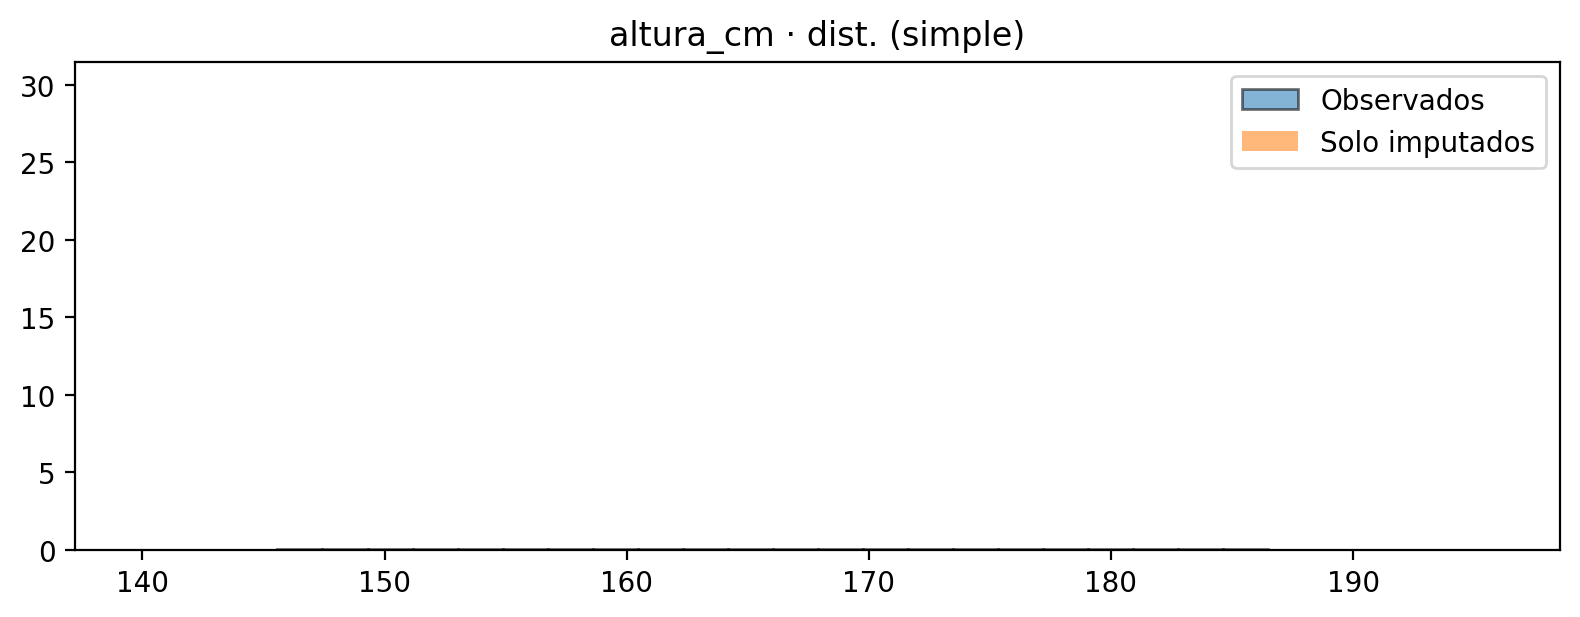

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


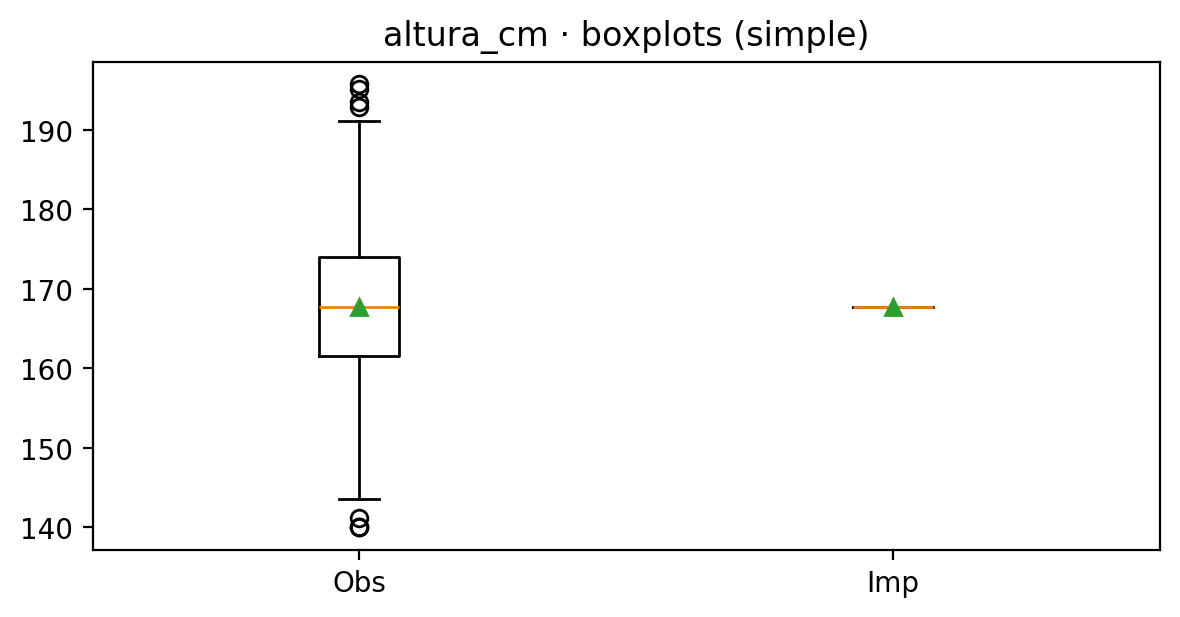

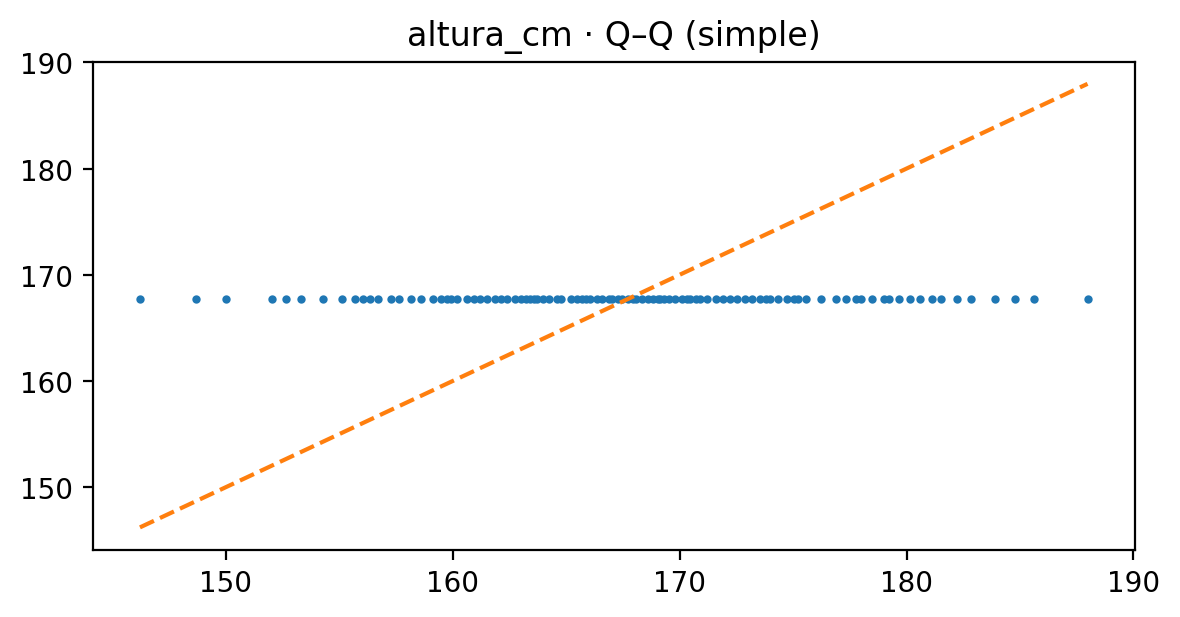

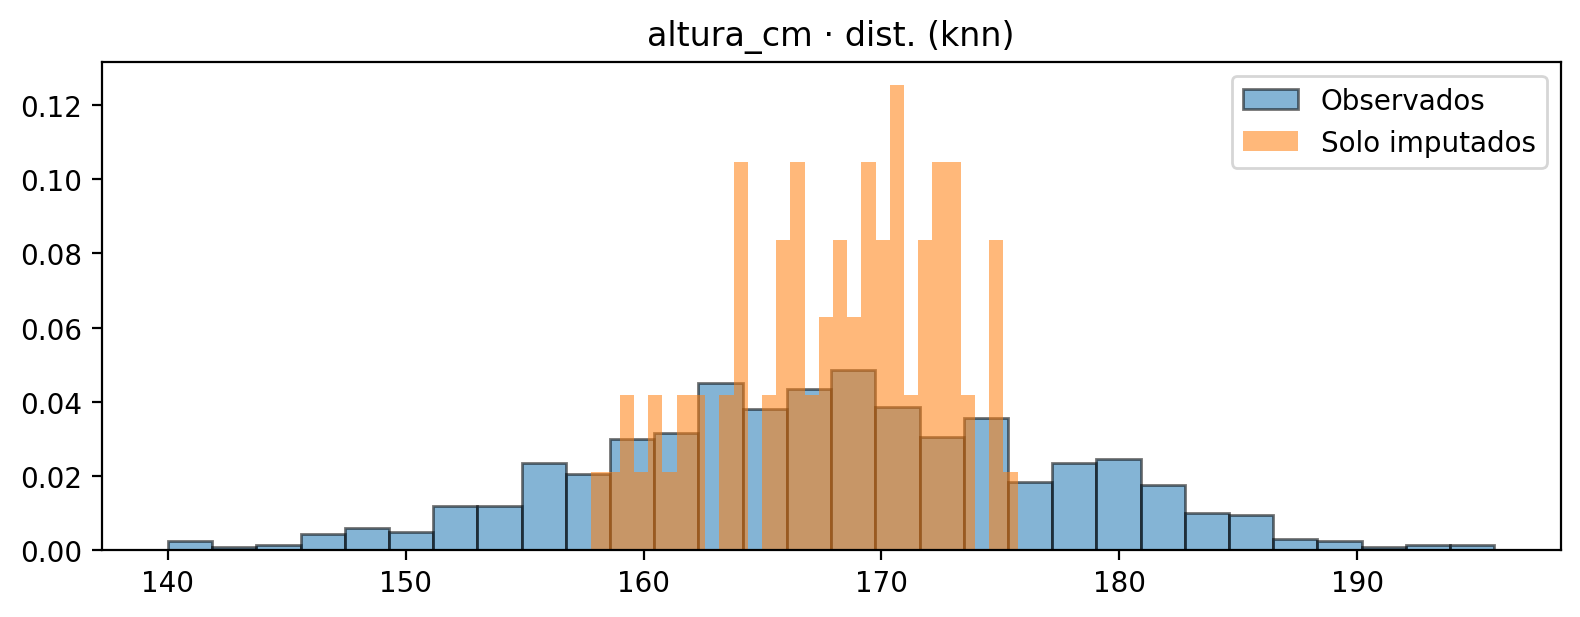

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


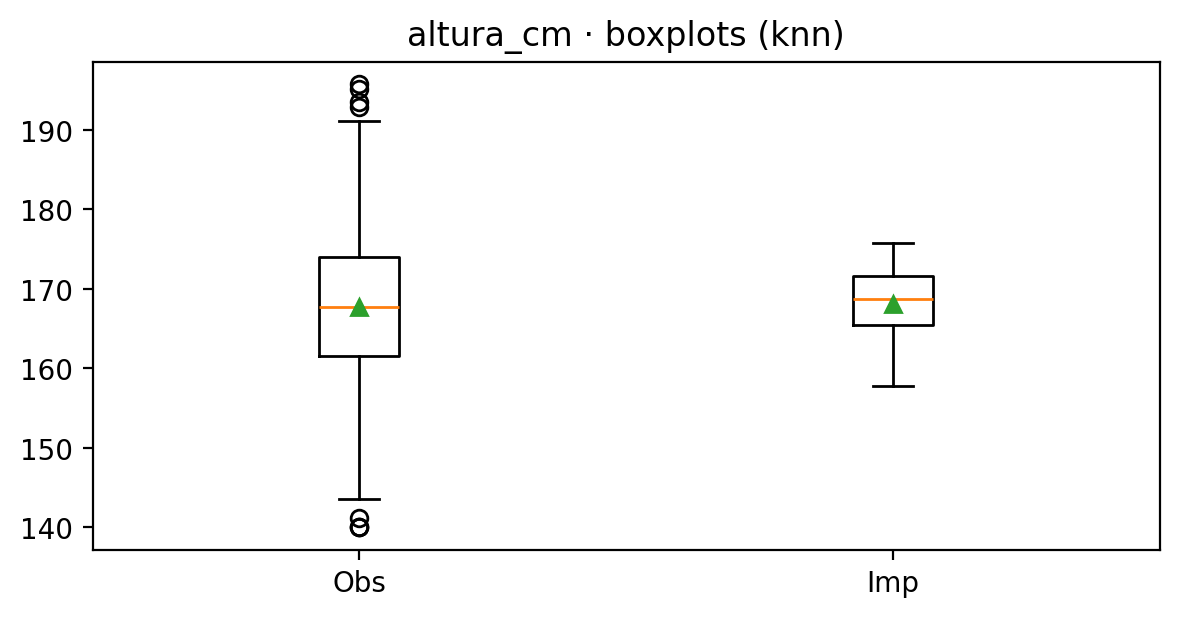

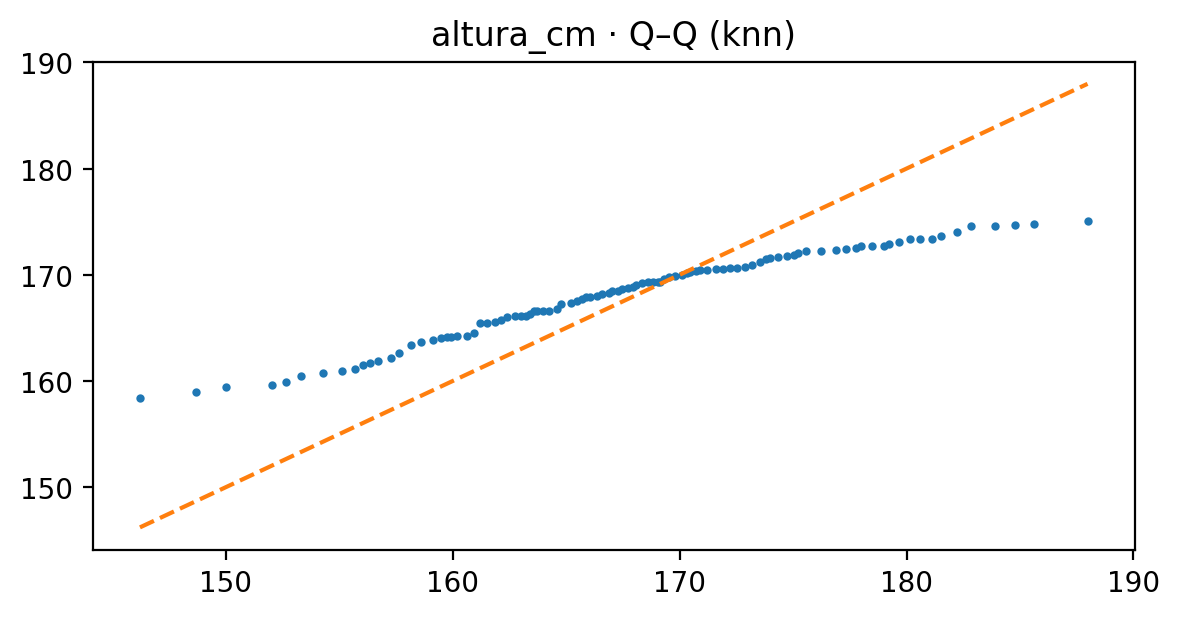

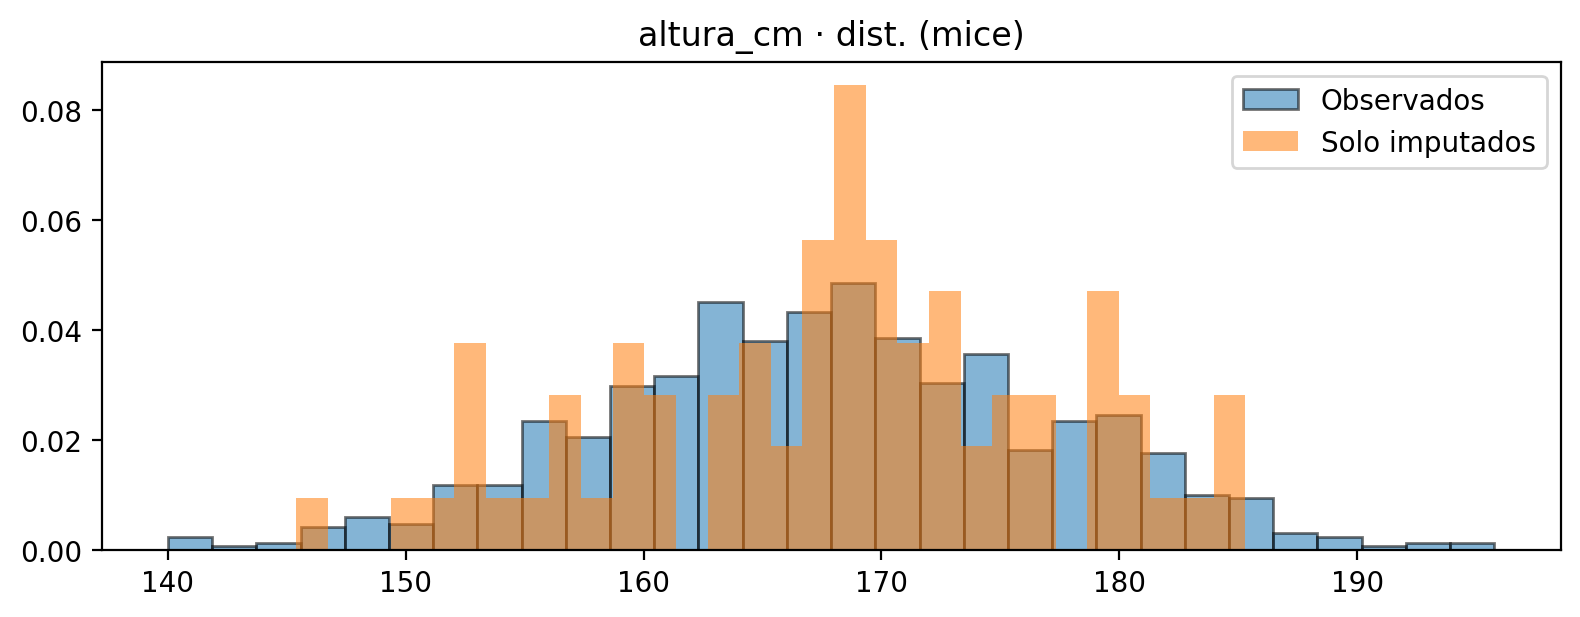

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


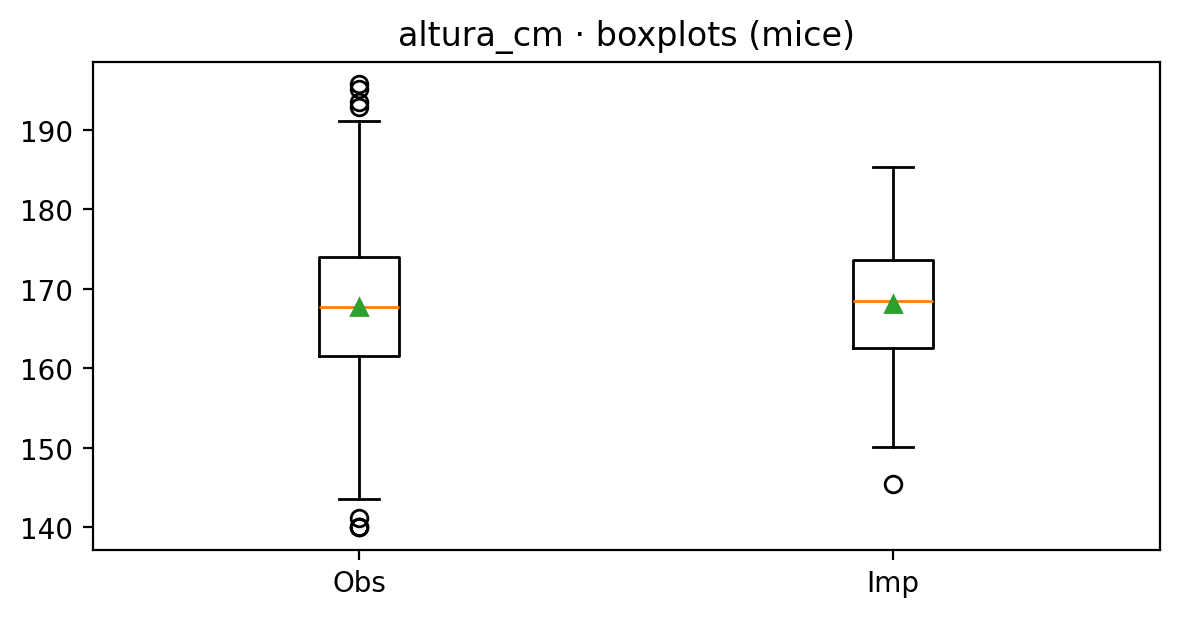

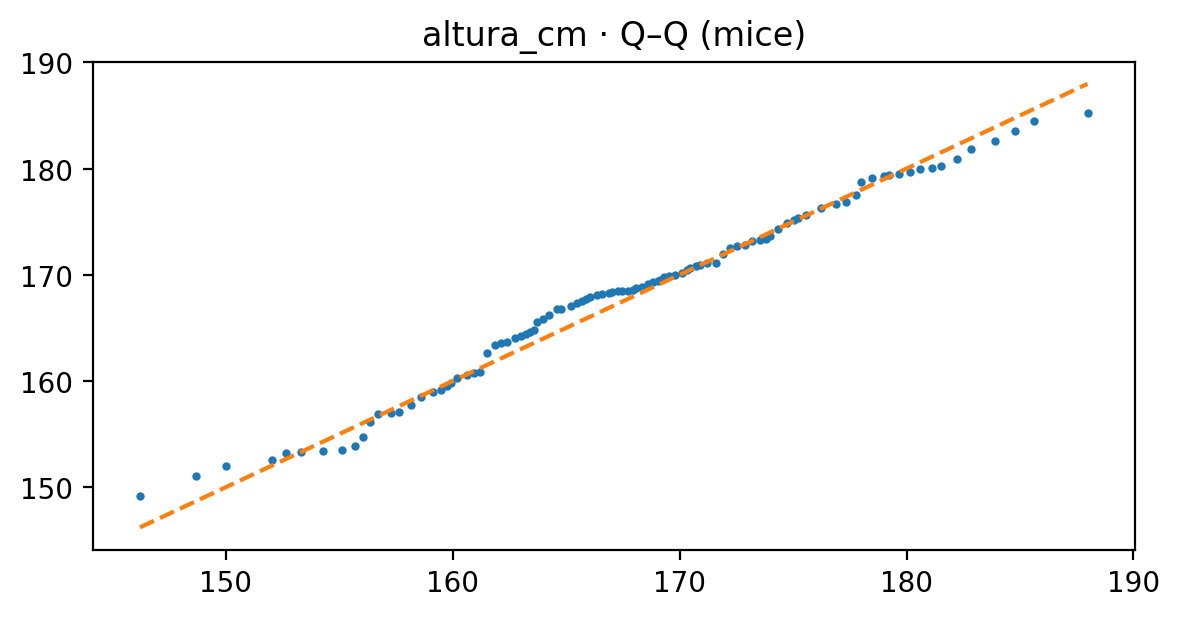

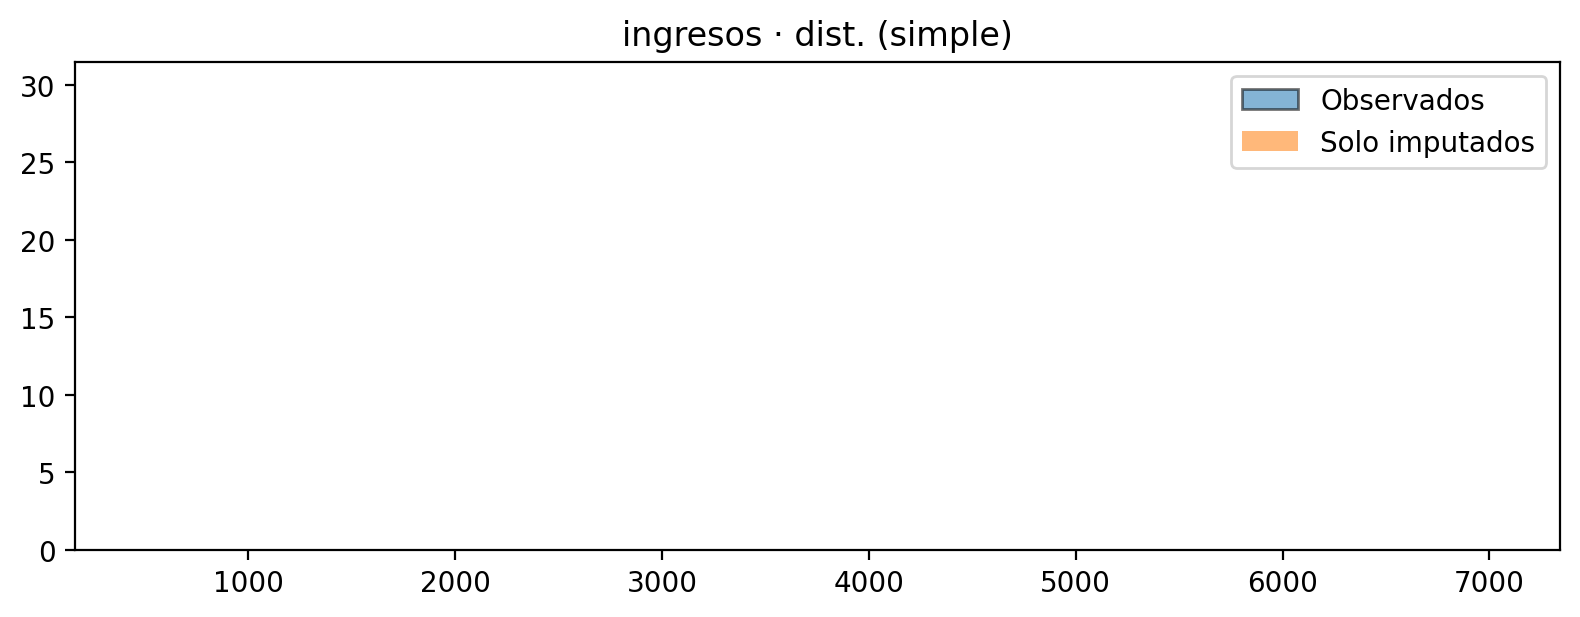

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


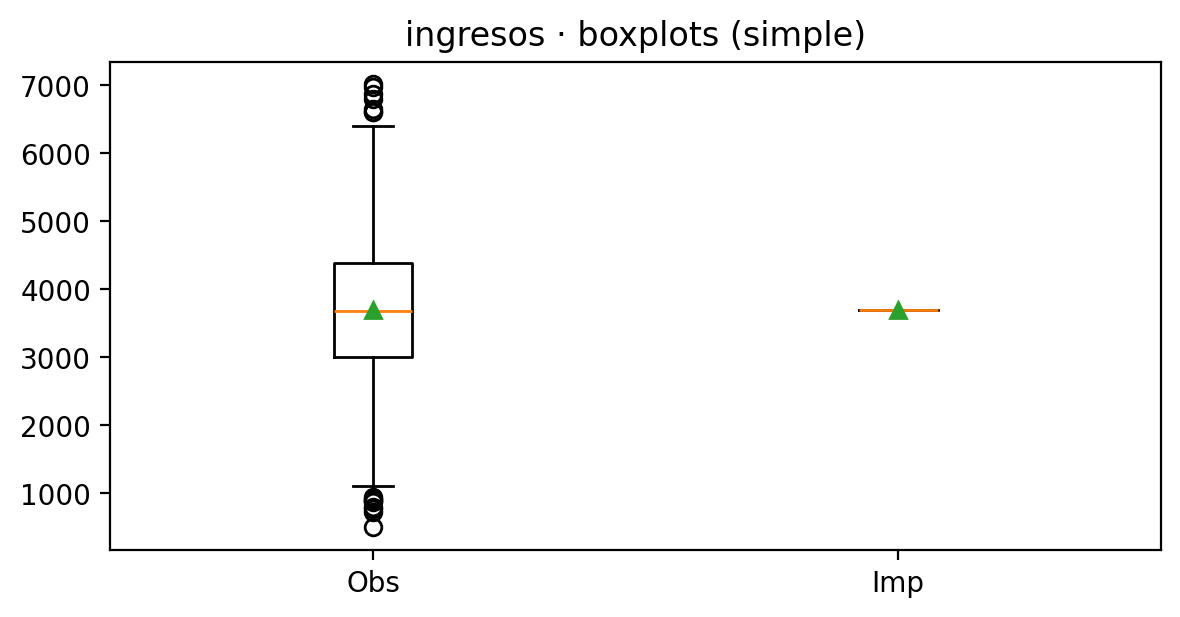

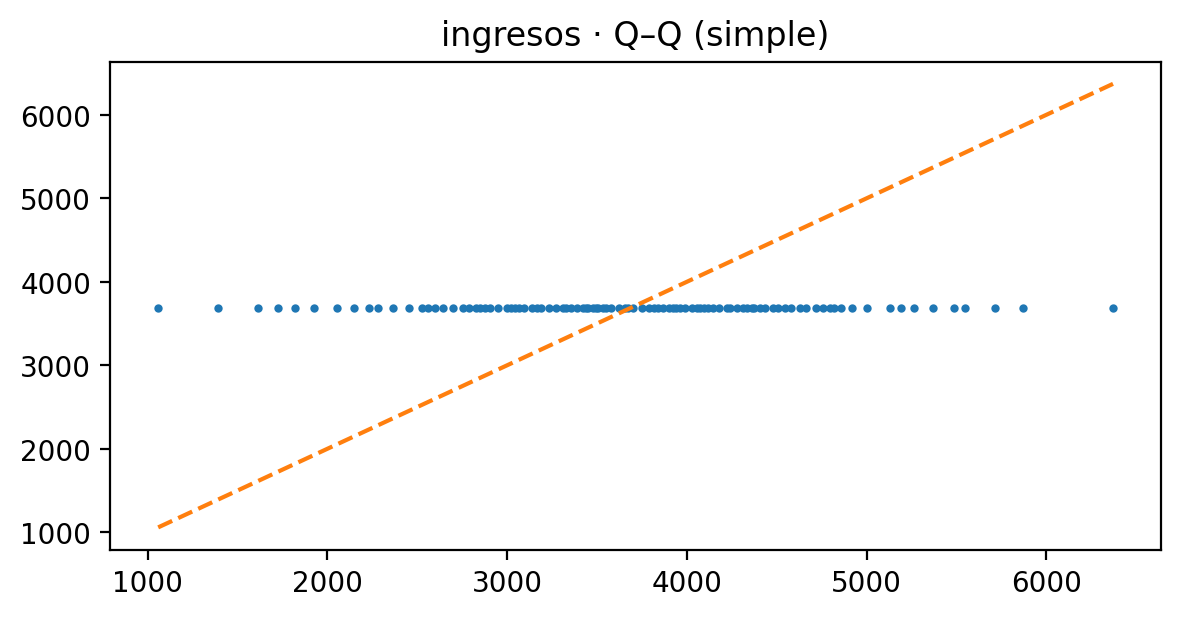

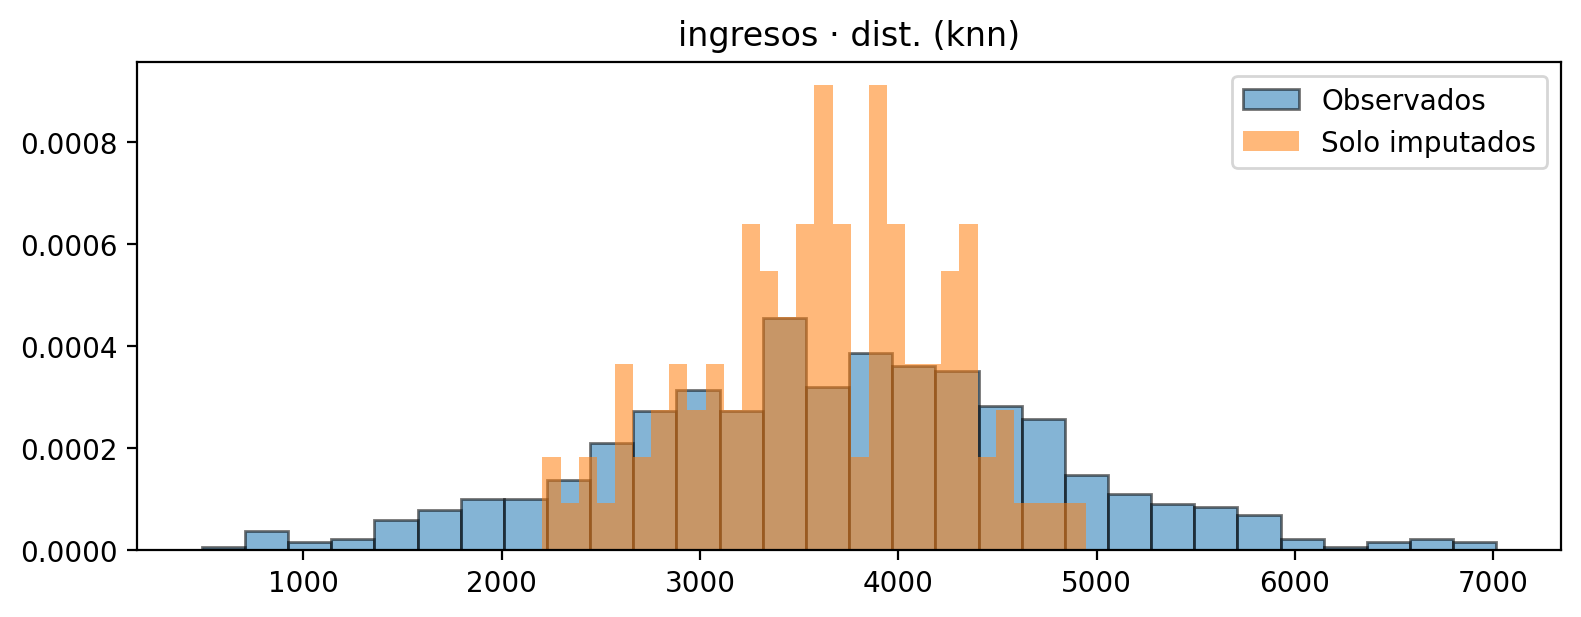

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


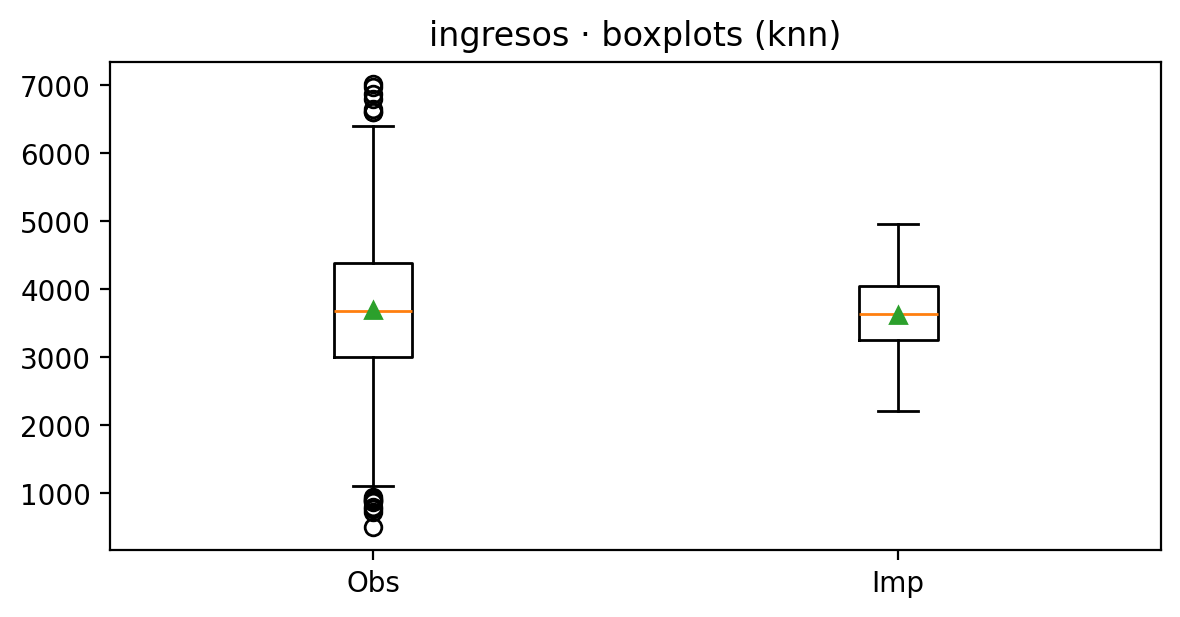

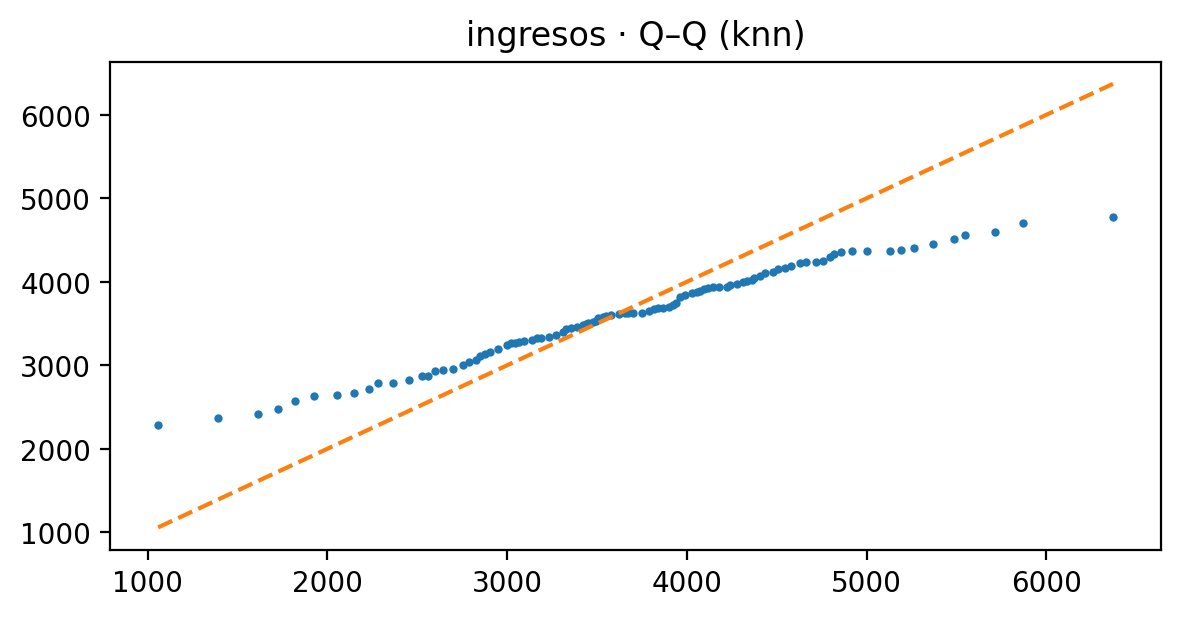

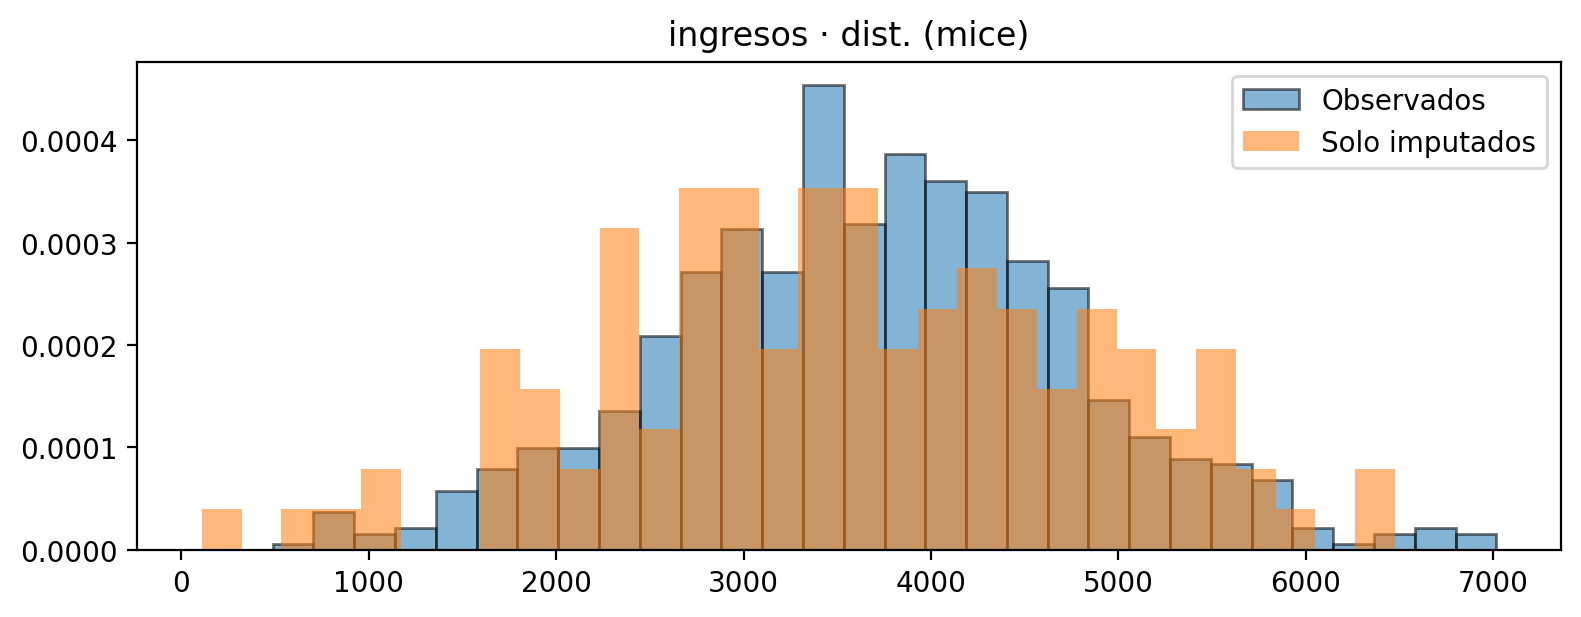

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


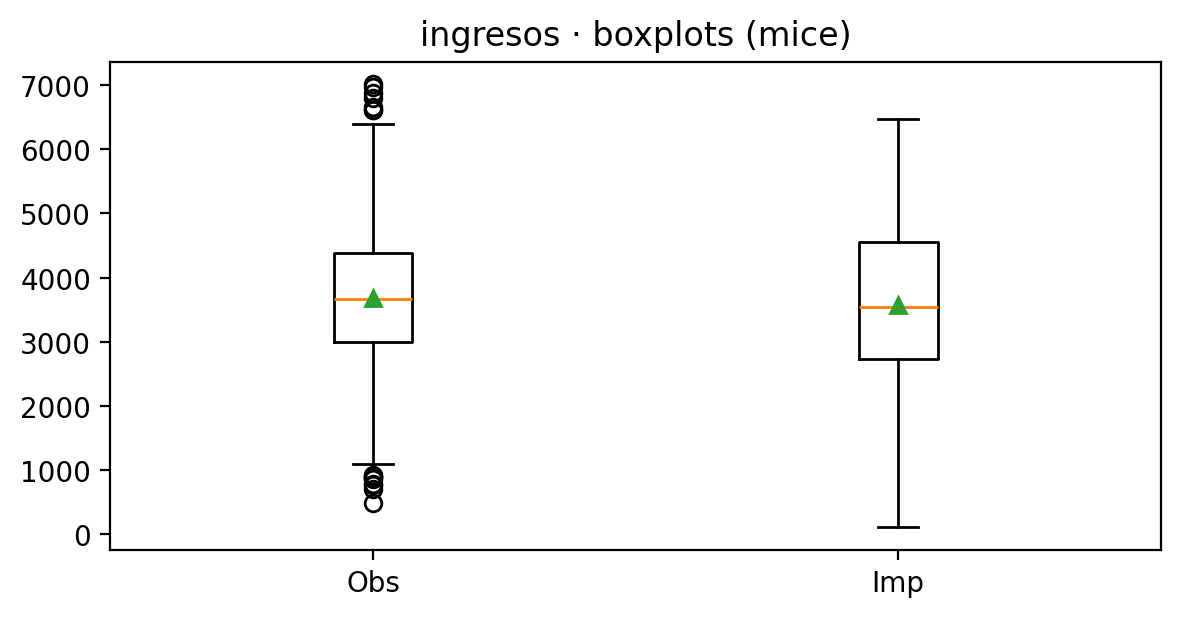

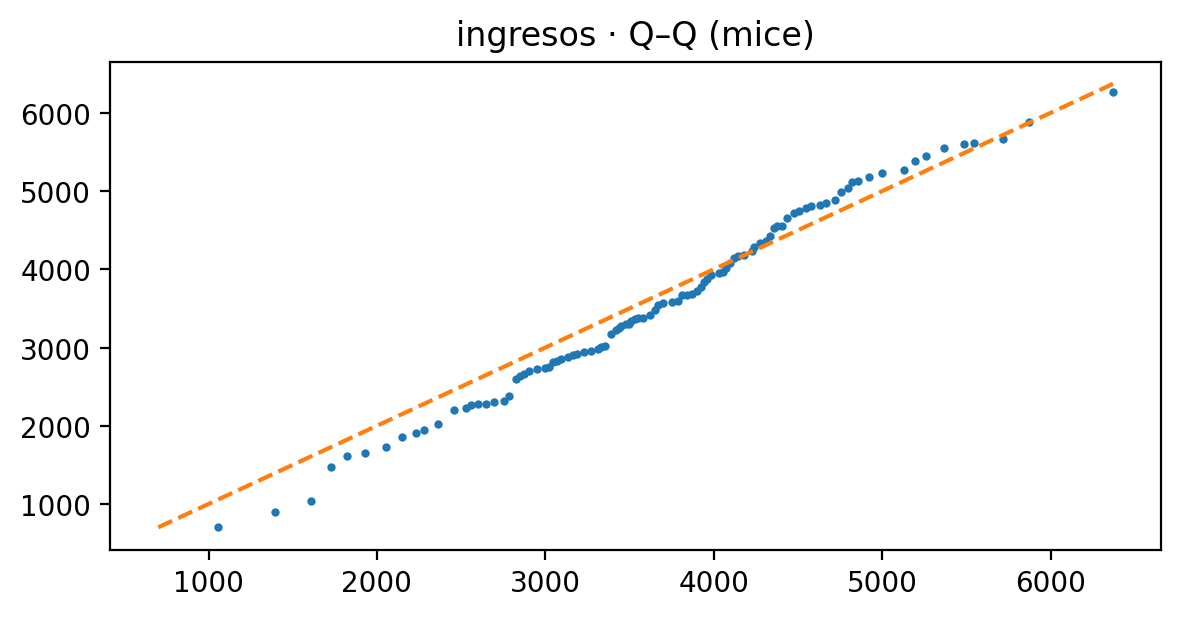

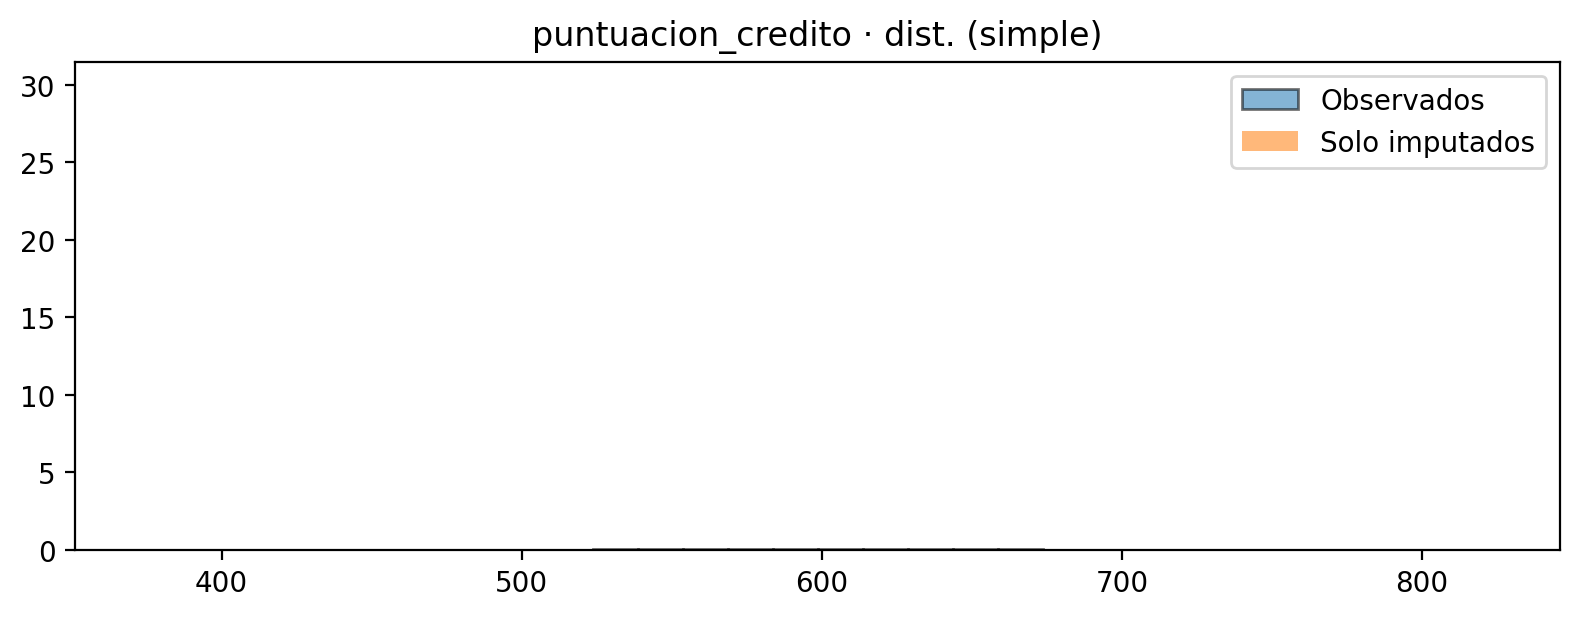

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


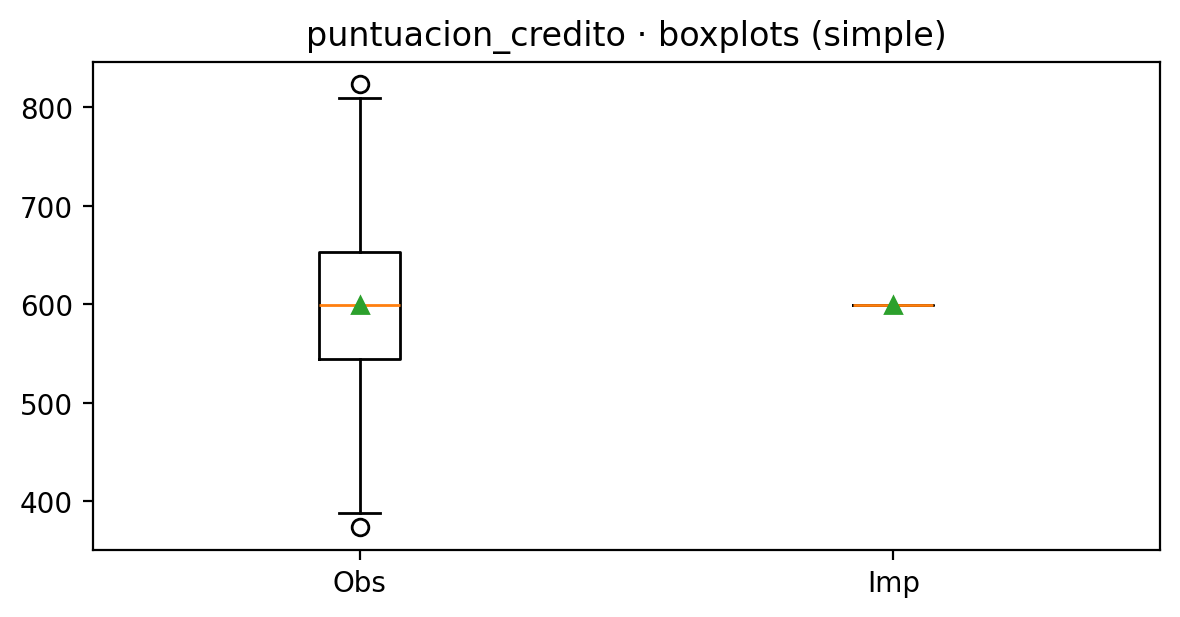

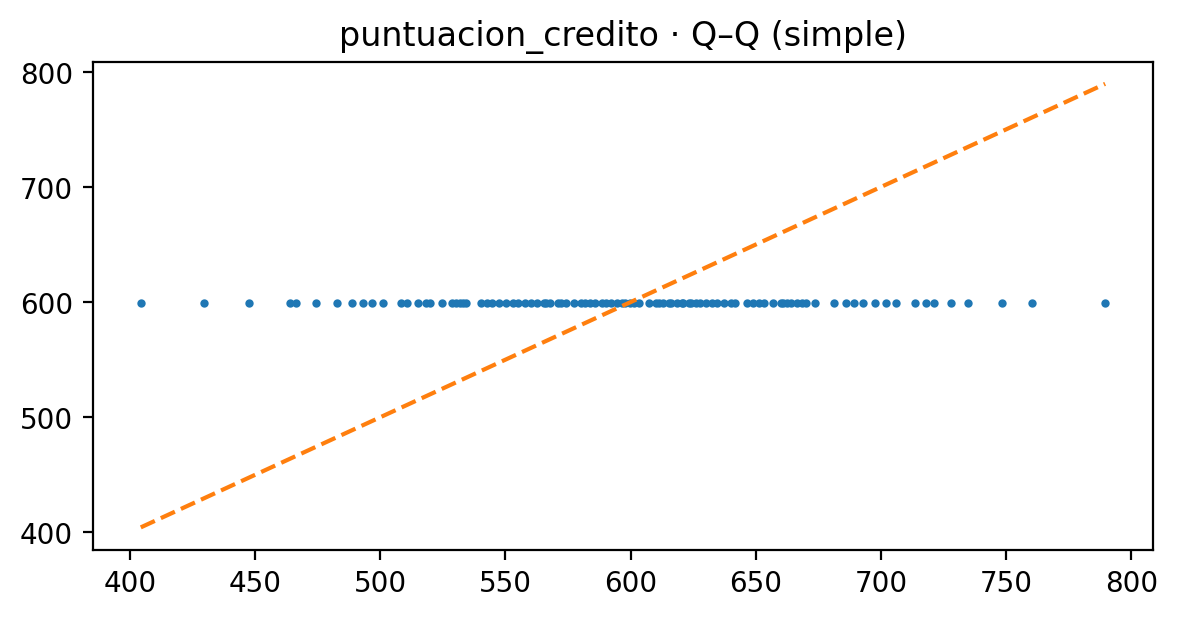

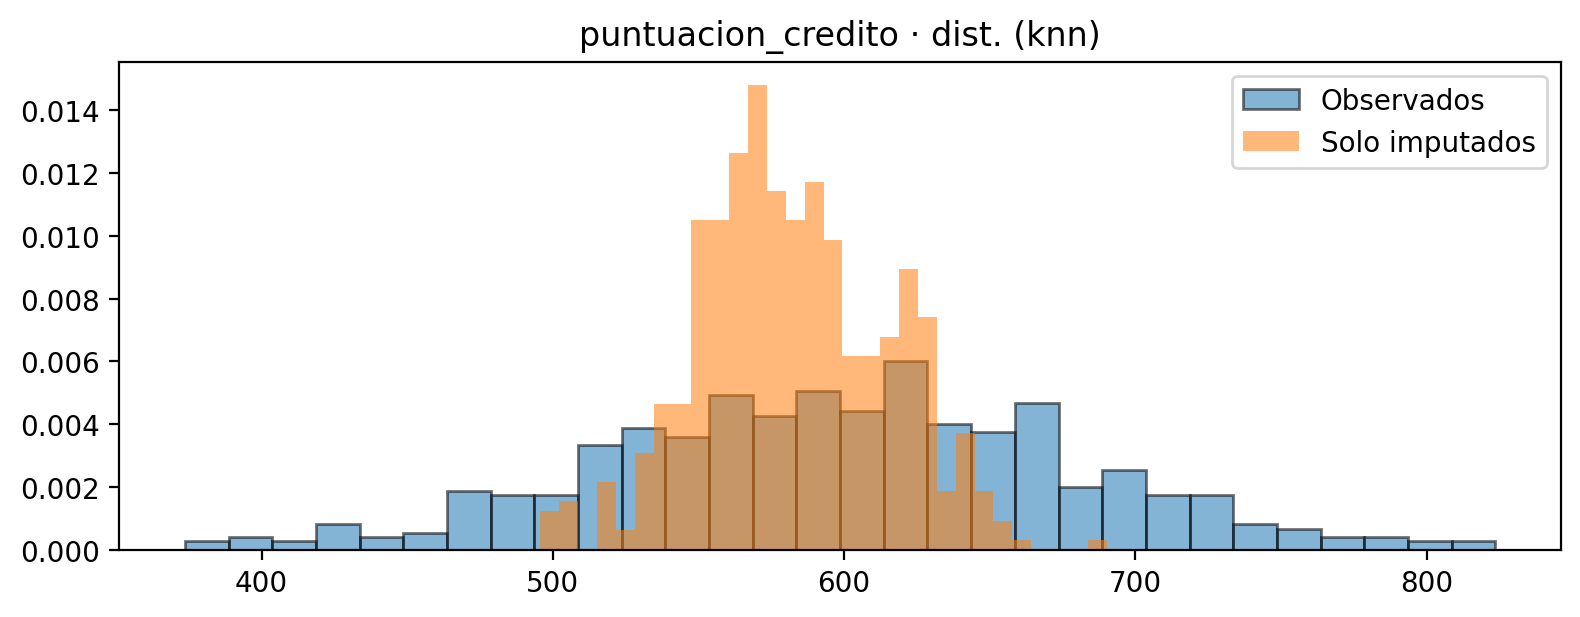

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


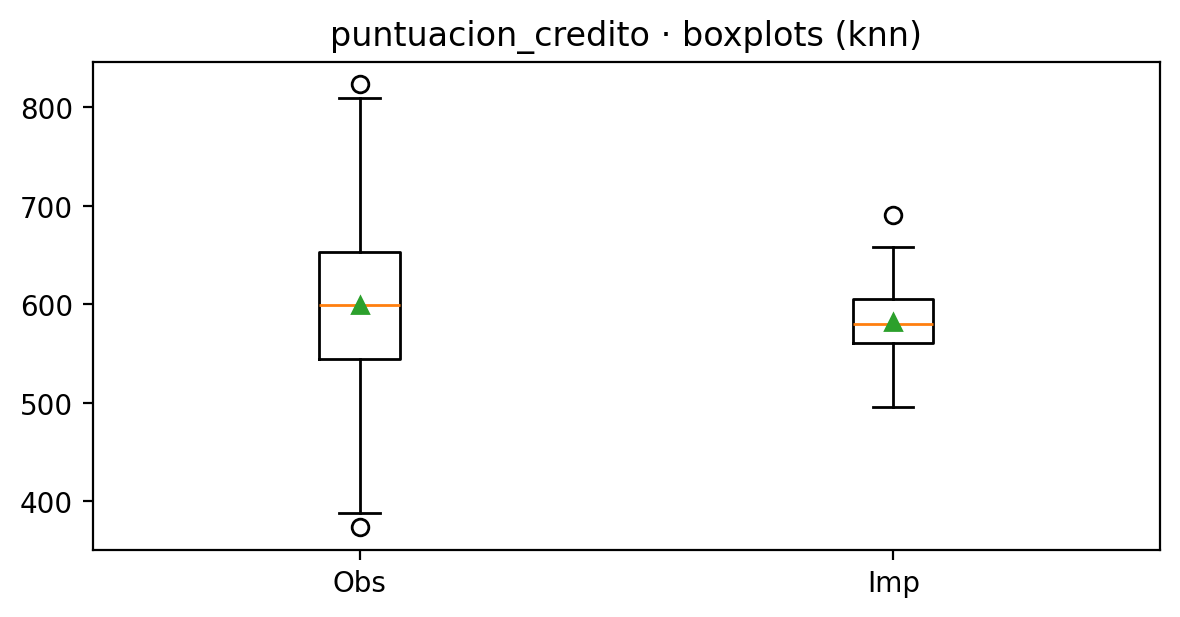

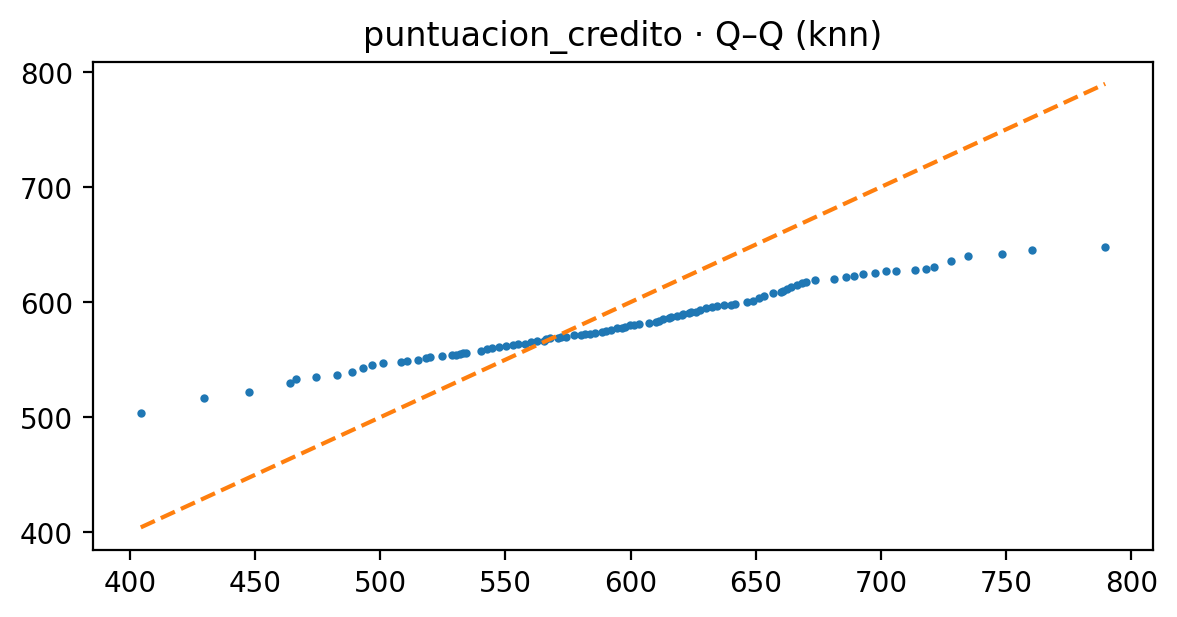

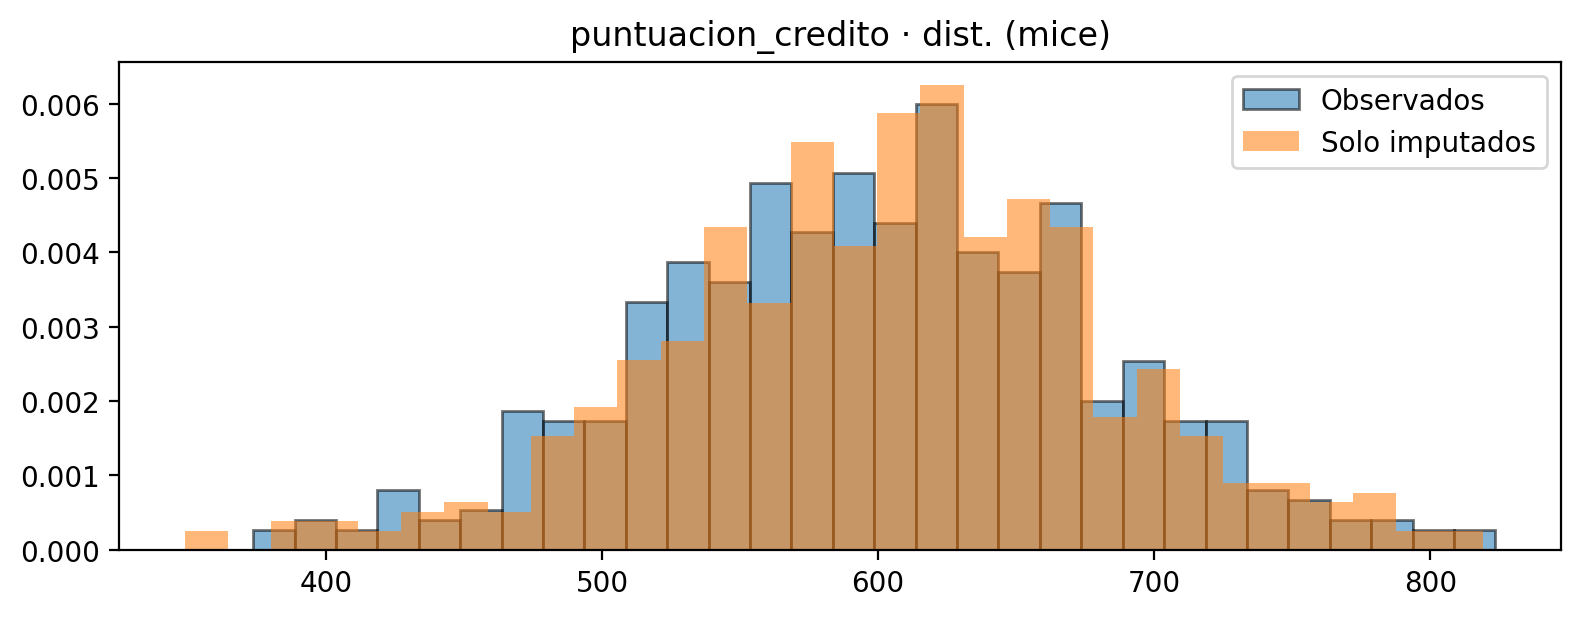

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


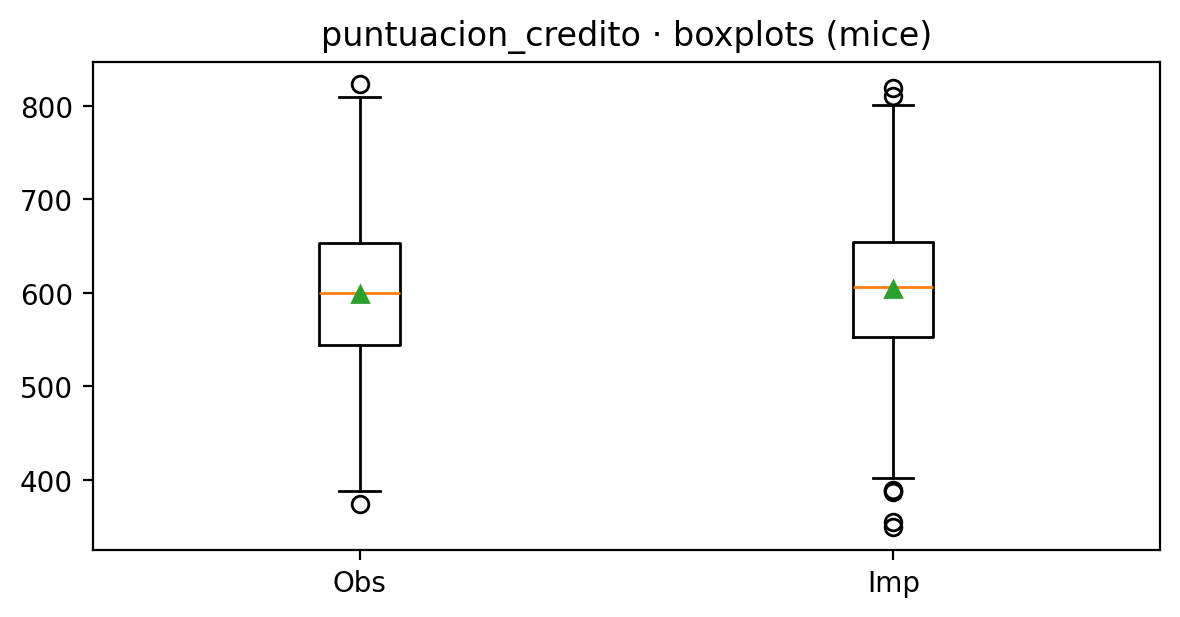

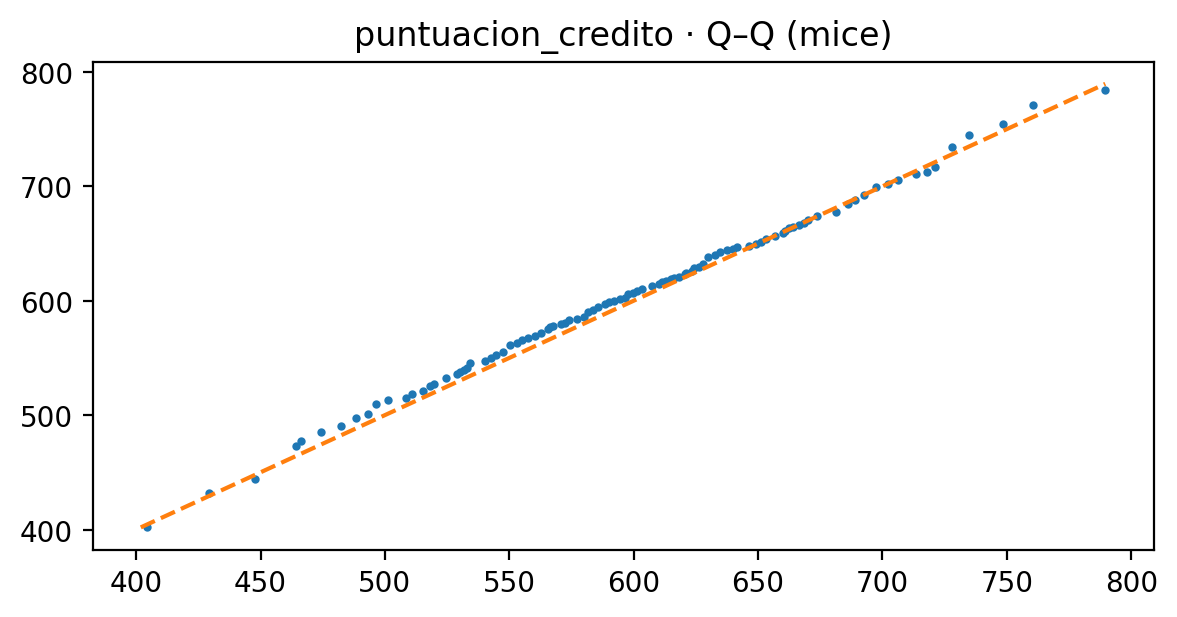

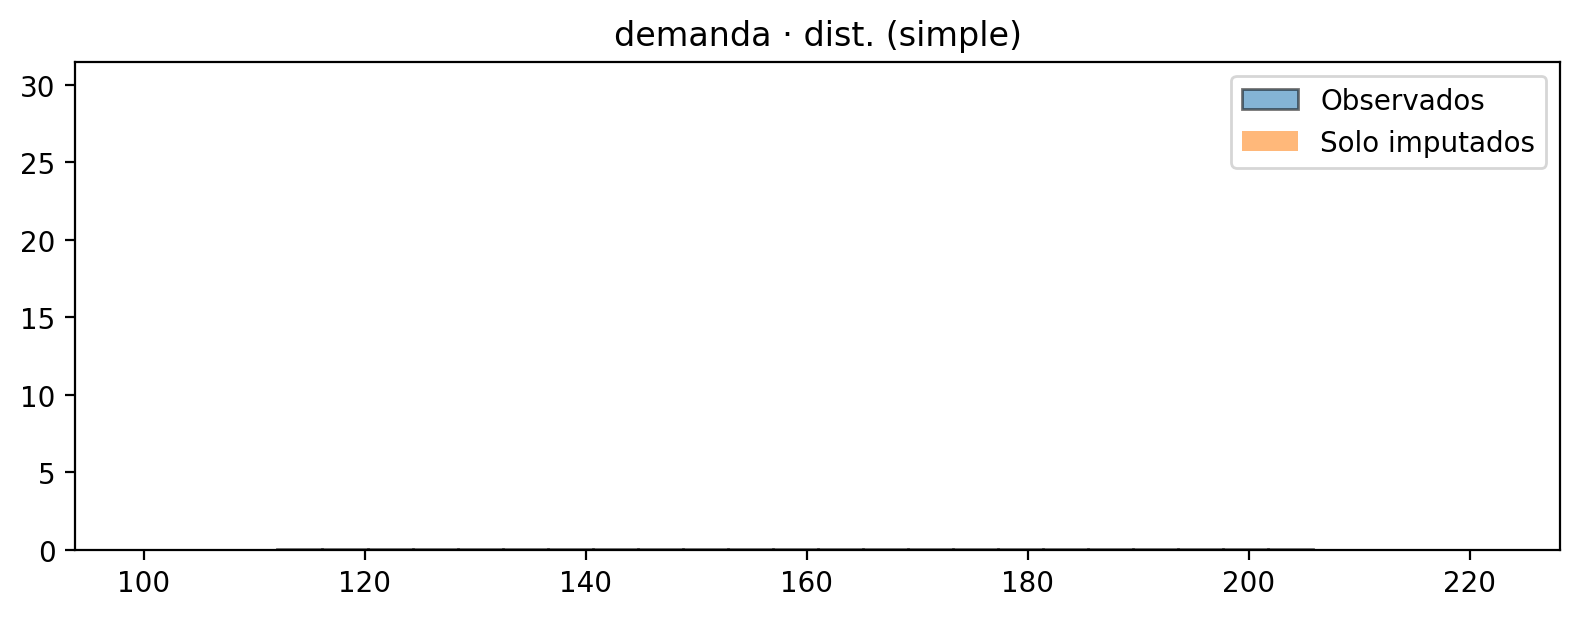

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


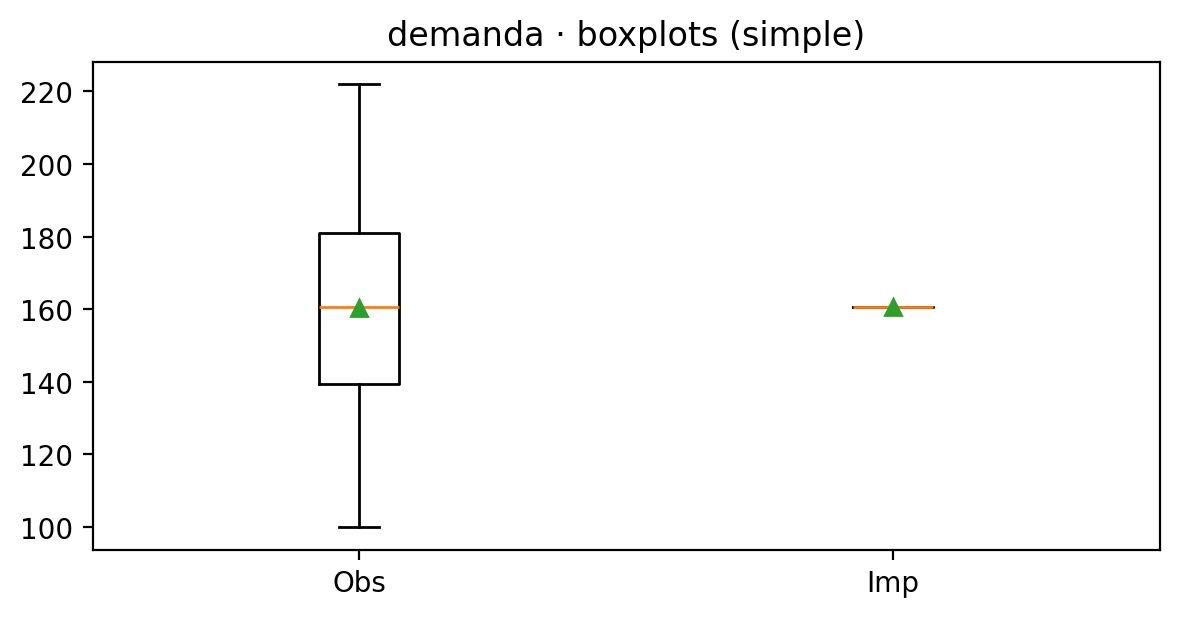

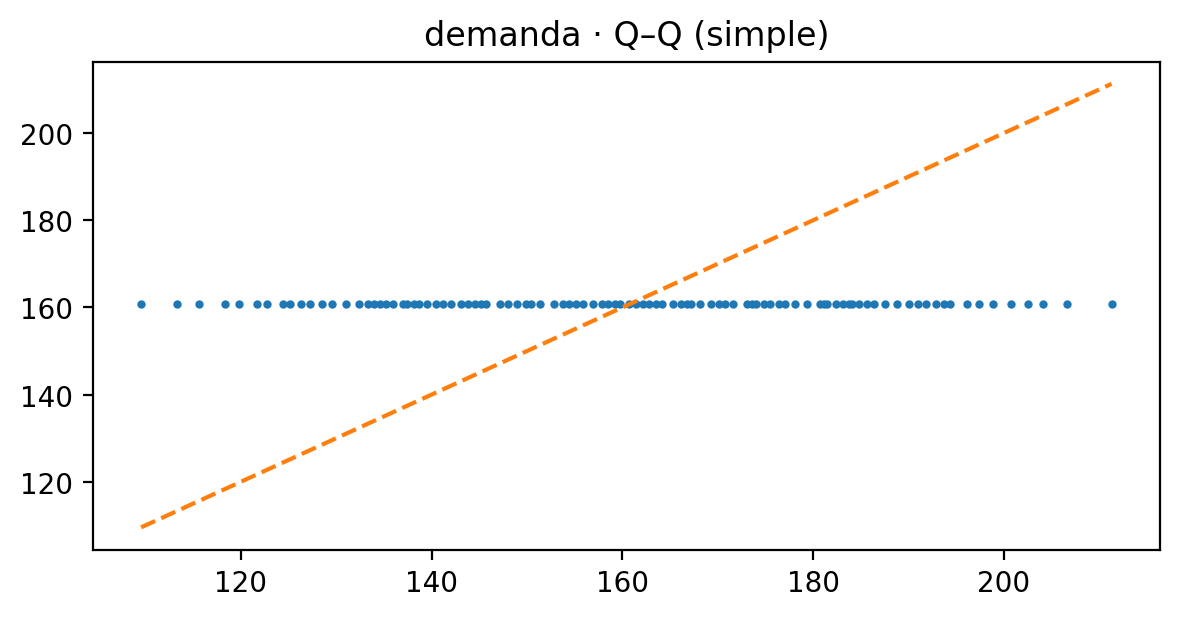

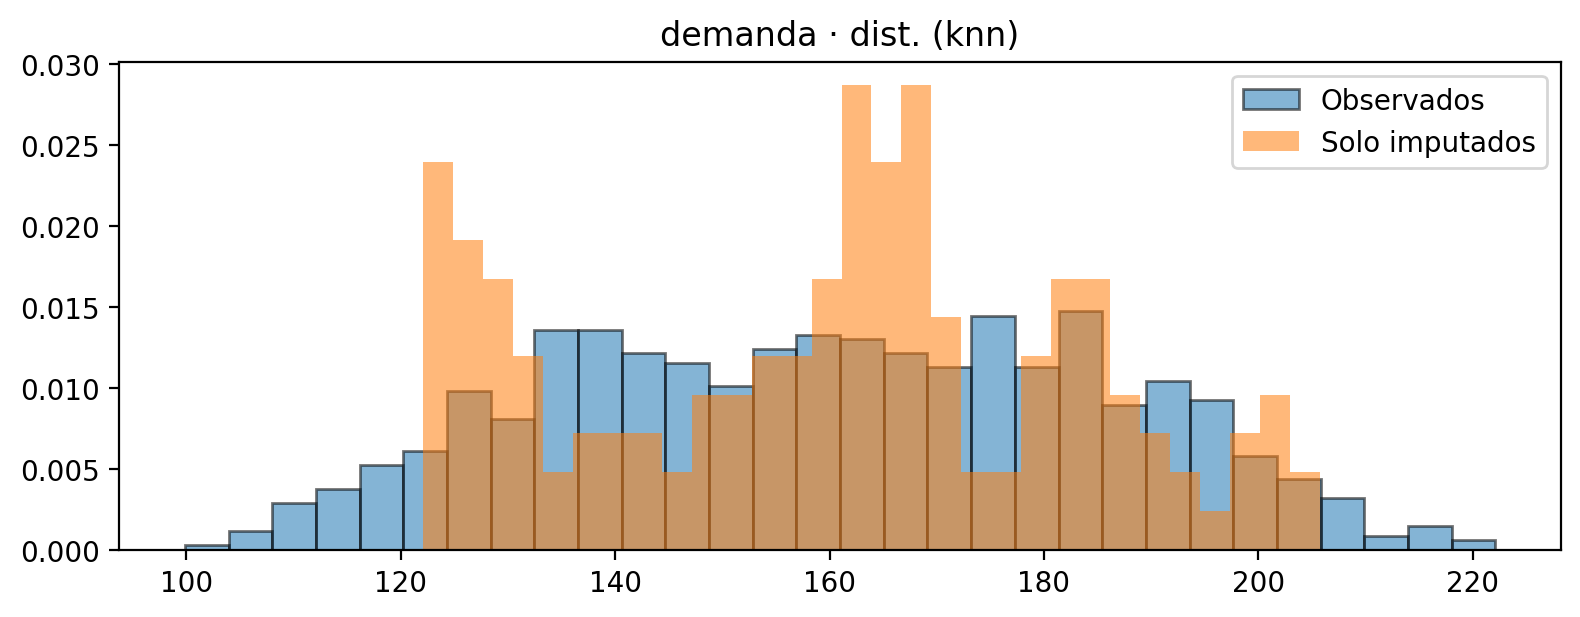

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


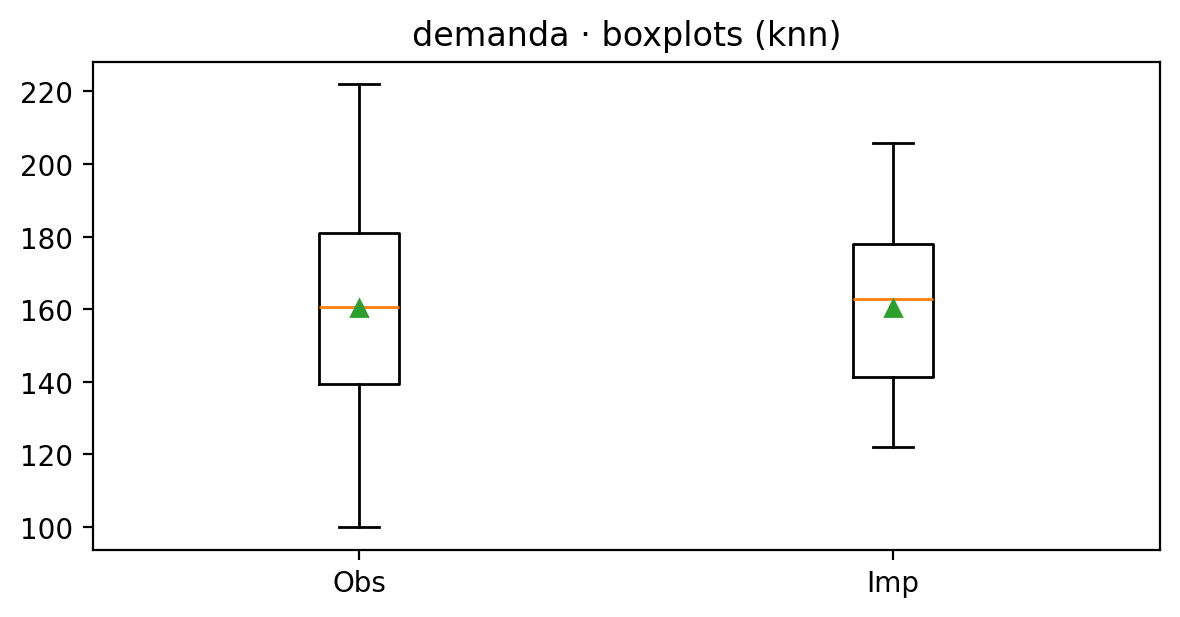

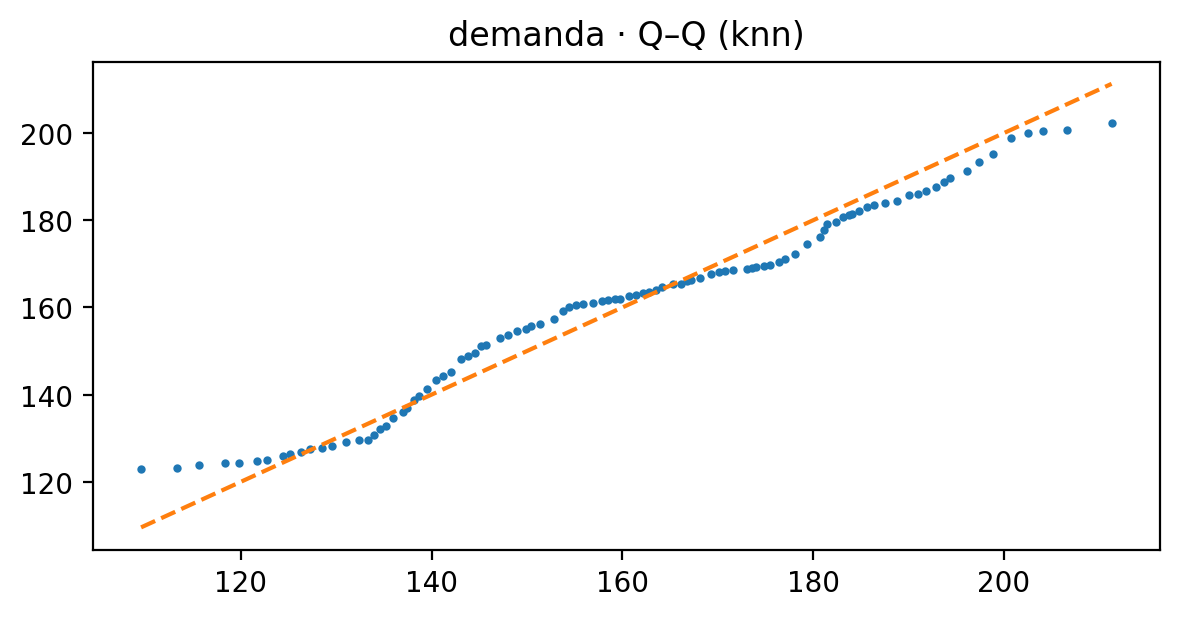

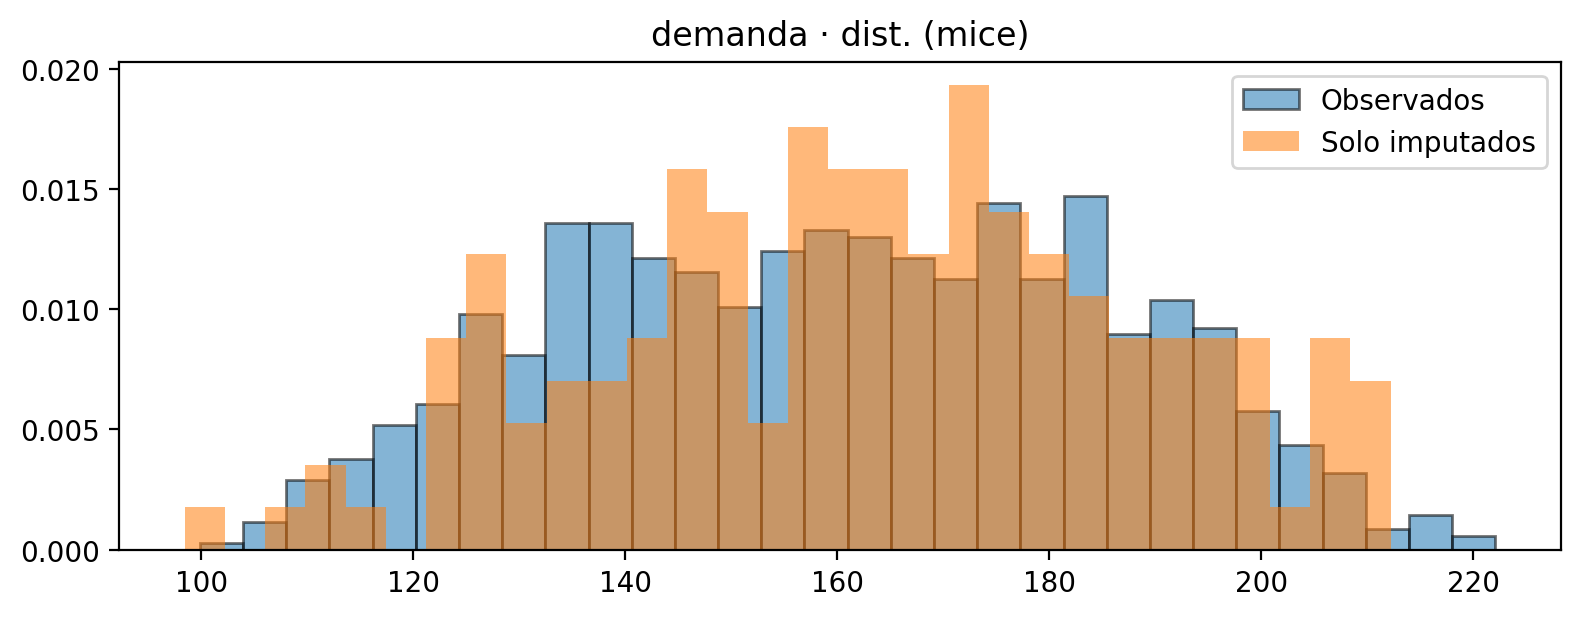

C:\Users\potot\AppData\Local\Temp\ipykernel_19736\1974011301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)


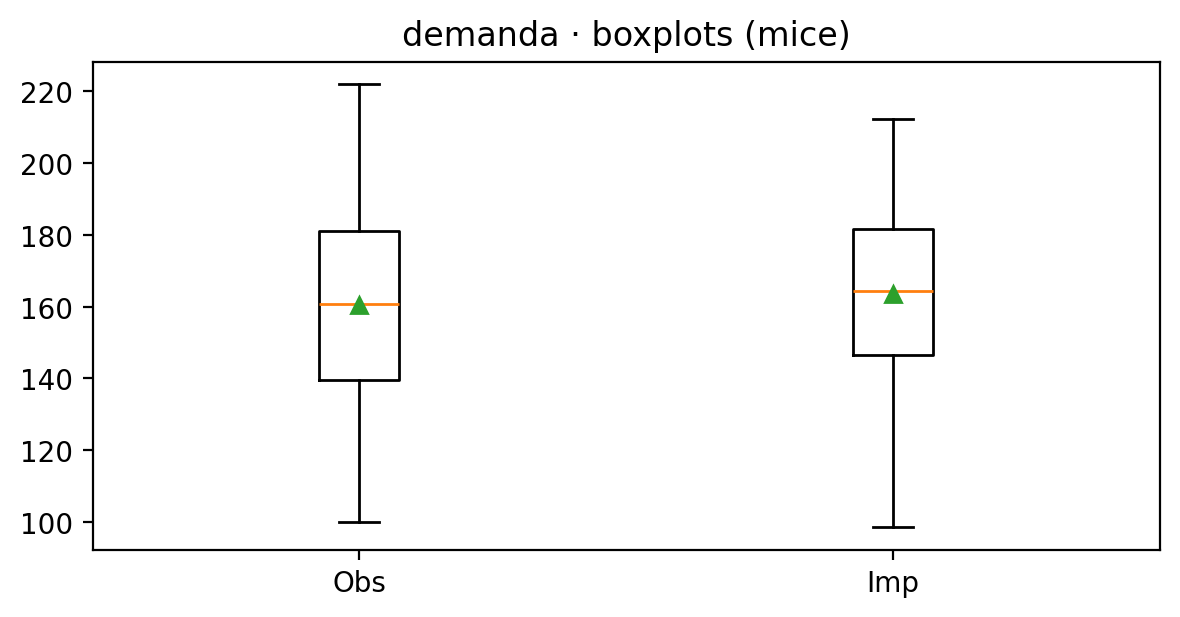

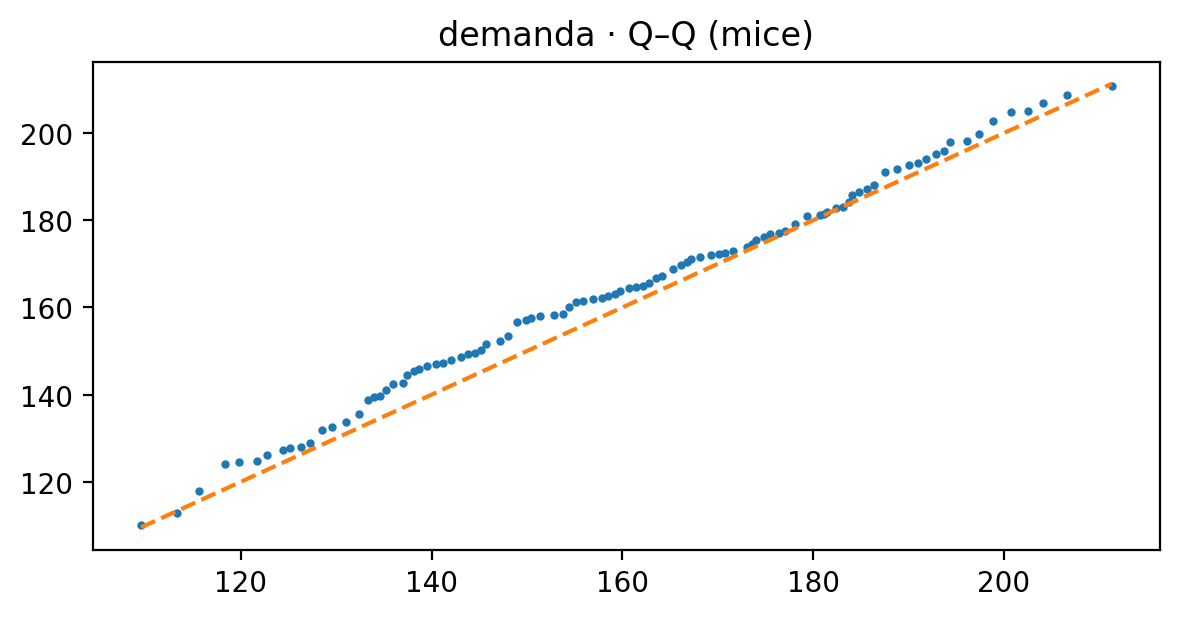

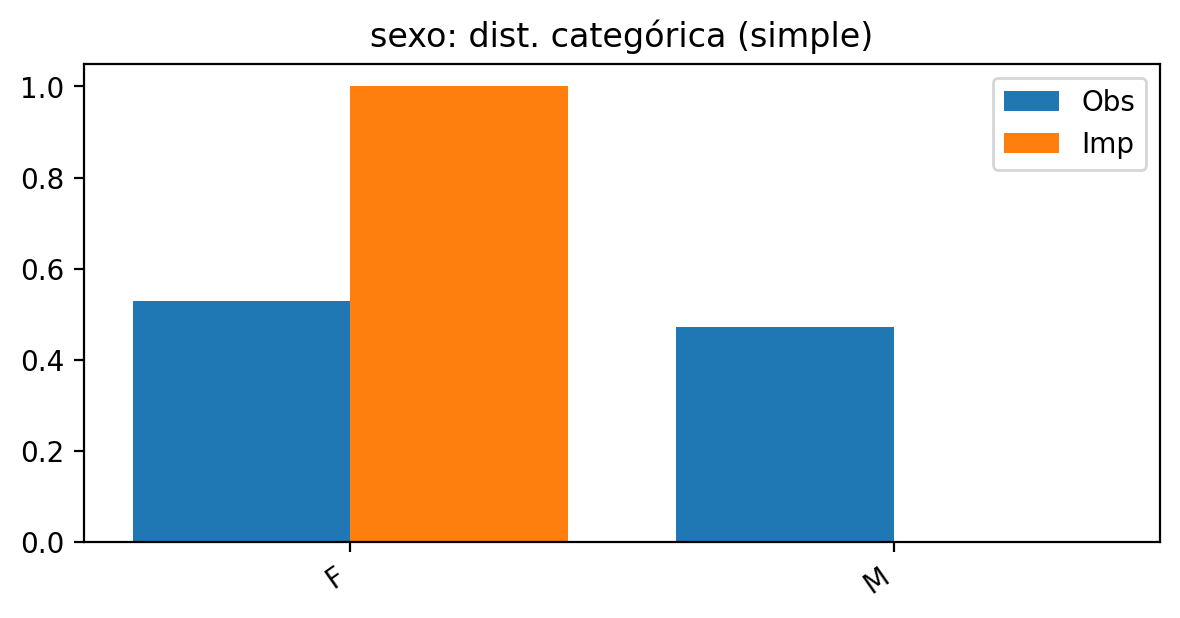

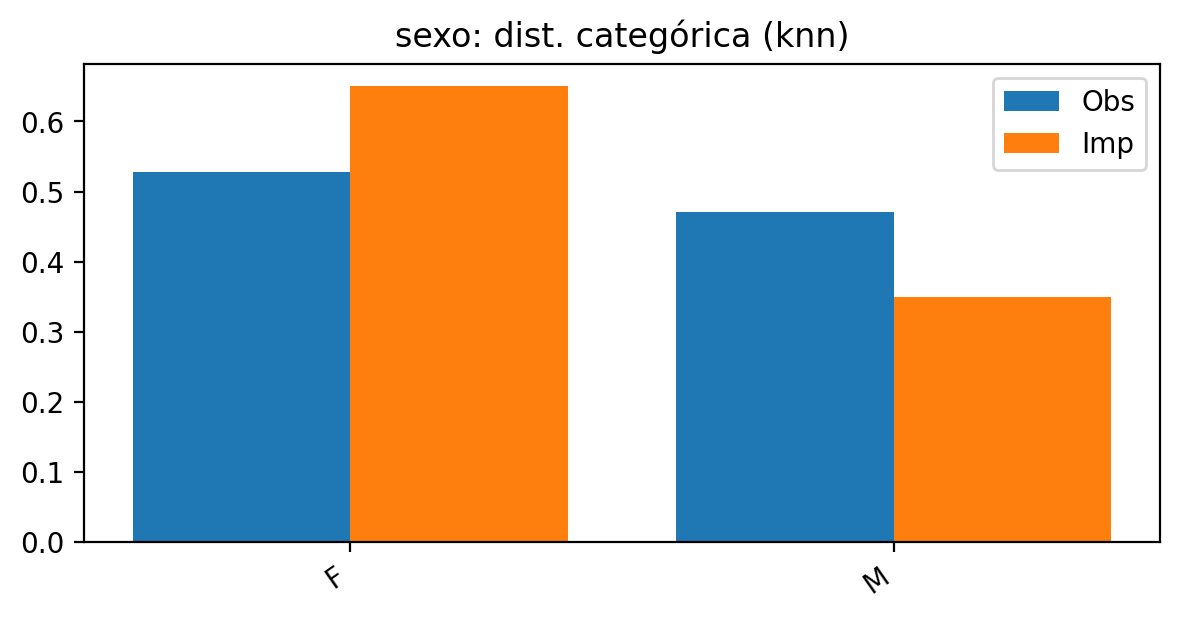

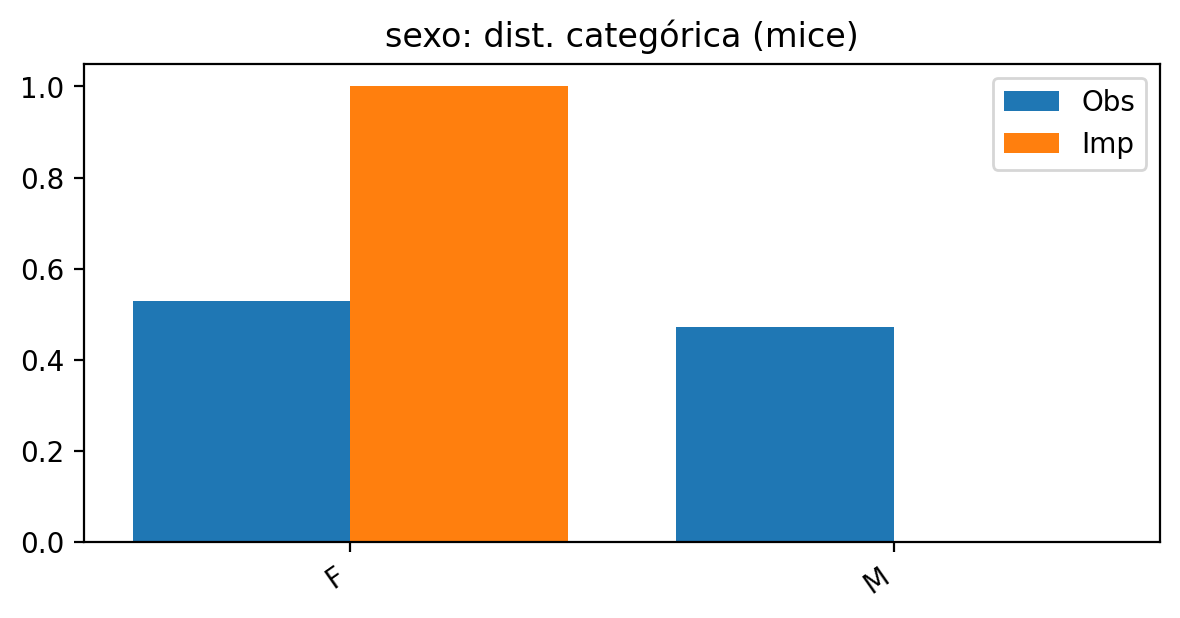

In [6]:

def graficar_num_pre_post(var, df_orig, df_imp, metodo_tag):
    obs = df_orig[var].dropna().values
    imp_only = df_imp.loc[df_orig[var].isna(), var].dropna().values
    if len(obs) == 0 or len(imp_only) == 0:
        return
    # Histograma
    plt.figure(figsize=(8,3.2))
    plt.hist(obs, bins=30, density=True, alpha=0.55, label="Observados", edgecolor="black")
    plt.hist(imp_only, bins=30, density=True, alpha=0.55, label="Solo imputados")
    plt.title(f"{var} · dist. ({metodo_tag})"); plt.legend(); plt.tight_layout(); plt.show()
    # Boxplot
    plt.figure(figsize=(6,3.2))
    plt.boxplot([obs, imp_only], labels=["Obs", "Imp"], showmeans=True)
    plt.title(f"{var} · boxplots ({metodo_tag})"); plt.tight_layout(); plt.show()
    # Q-Q
    q = np.linspace(0.01, 0.99, 99)
    qo = np.quantile(obs, q); qi = np.quantile(imp_only, q)
    plt.figure(figsize=(6,3.2))
    plt.plot(qo, qi, ".", ms=4); lo, hi = min(qo.min(), qi.min()), max(qo.max(), qi.max())
    plt.plot([lo,hi],[lo,hi],"--")
    plt.title(f"{var} · Q–Q ({metodo_tag})"); plt.tight_layout(); plt.show()

def graficar_cat_pre_post(var, df_orig, df_imp, metodo_tag):
    obs = df_orig[var].dropna()
    imp_only = df_imp.loc[df_orig[var].isna(), var].dropna()
    if obs.empty or imp_only.empty:
        return
    f_obs = obs.value_counts(normalize=True).sort_index()
    f_imp = imp_only.value_counts(normalize=True).reindex(f_obs.index, fill_value=0)
    x = np.arange(len(f_obs)); width = 0.4
    plt.figure(figsize=(max(6, len(f_obs)*0.8), 3.2))
    plt.bar(x-width/2, f_obs.values, width, label="Obs")
    plt.bar(x+width/2, f_imp.values, width, label="Imp")
    plt.xticks(x, f_obs.index, rotation=35, ha="right")
    plt.title(f"{var}: dist. categórica ({metodo_tag})"); plt.legend(); plt.tight_layout(); plt.show()

# Generar ejemplos para variables clave
for var in num_cols:
    for tag, dfi in [("simple", df_simple), ("knn", df_knn), ("mice", df_mice)]:
        graficar_num_pre_post(var, df, dfi, tag)

for var in cat_cols:
    for tag, dfi in [("simple", df_simple), ("knn", df_knn), ("mice", df_mice)]:
        graficar_cat_pre_post(var, df, dfi, tag)


## 5. Cómo leer los gráficos de “observados vs imputados”

- **Imputación Simple** (media/mediana/moda) → los imputados toman **un solo valor**:
  - Histograma: **una barra naranja** (sin variabilidad).
  - Boxplot: punto/línea concentrada.
  - Q–Q: línea horizontal en los cuantiles imputados.  
  > Esto **no preserva** la distribución y sesga varianza. Se deja solo como **línea base didáctica**.

- **KNN** y **MICE** → generan **variabilidad** y, si están bien calibrados, los histogramas/boxplots/Q–Q de imputados se parecen a los observados.

**Criterio de preservación (numéricas)**
- **KS** (2 muestras) p > 0.05 **y**
- **t de Student** (si ambos normales) o **Mann–Whitney U** (si no) con p > 0.05.

**Criterio de preservación (categóricas)**
- **Chi²** p > 0.05 (proporciones comparables).


In [7]:

def test_num(var, df_orig, df_imp):
    obs = df_orig[var].dropna().values
    imp_only = df_imp.loc[df_orig[var].isna(), var].dropna().values
    if len(obs) < 10 or len(imp_only) < 10:
        return {"KS_p": np.nan, "shapiro_obs_p": np.nan, "shapiro_imp_p": np.nan, "test": "NA", "p_val_test": np.nan}
    sh_obs = stats.shapiro(pd.Series(obs).sample(min(len(obs), 500), random_state=42))[1]
    sh_imp = stats.shapiro(pd.Series(imp_only).sample(min(len(imp_only), 500), random_state=42))[1]
    ks_p = stats.ks_2samp(obs, imp_only, alternative="two-sided", mode="auto")[1]
    if sh_obs > 0.05 and sh_imp > 0.05:
        t_p = stats.ttest_ind(obs, imp_only, equal_var=False, nan_policy="omit")[1]
        return {"KS_p": ks_p, "shapiro_obs_p": sh_obs, "shapiro_imp_p": sh_imp, "test": "t_student", "p_val_test": t_p}
    else:
        u_p = stats.mannwhitneyu(obs, imp_only, alternative="two-sided")[1]
        return {"KS_p": ks_p, "shapiro_obs_p": sh_obs, "shapiro_imp_p": sh_imp, "test": "mann_whitney", "p_val_test": u_p}

def test_cat(var, df_orig, df_imp):
    obs = df_orig[var].dropna()
    imp_only = df_imp.loc[df_orig[var].isna(), var].dropna()
    if obs.empty or imp_only.empty:
        return {"chi2_p": np.nan}
    cats = sorted(set(obs.unique()).union(set(imp_only.unique())))
    obs_f = obs.value_counts().reindex(cats, fill_value=0).values
    imp_f = imp_only.value_counts().reindex(cats, fill_value=0).values
    cont = np.vstack([obs_f, imp_f])
    if (cont > 0).sum() < 2:
        return {"chi2_p": np.nan}
    chi2, p, _, _ = stats.chi2_contingency(cont)
    return {"chi2_p": p}

def evaluar_todo(df_imp, tag):
    filas = []
    for var in [x for x in num_cols]:
        m = test_num(var, df, df_imp); m.update({"variable": var, "tipo": "numerica", "metodo": tag}); filas.append(m)
    for var in [x for x in cat_cols]:
        m = test_cat(var, df, df_imp); m.update({"variable": var, "tipo": "categorica", "metodo": tag}); filas.append(m)
    return pd.DataFrame(filas)

eval_simple = evaluar_todo(df_simple, "simple")
eval_knn    = evaluar_todo(df_knn,    "knn")
eval_mice   = evaluar_todo(df_mice,   "mice")

eval_all = pd.concat([eval_simple, eval_knn, eval_mice], ignore_index=True)
print("\n=== Resultados de pruebas (p-valores) ===")
display(eval_all.head(30))
eval_all.to_csv(OUT_DIR/"10_evaluacion_tests.csv", index=False)

# Criterio de preservación
def preserva_fila(row):
    if row["tipo"] == "numerica":
        return (pd.notna(row.get("KS_p")) and row["KS_p"] > 0.05) and                (pd.notna(row.get("p_val_test")) and row["p_val_test"] > 0.05)
    else:
        return (pd.notna(row.get("chi2_p")) and row["chi2_p"] > 0.05)

eval_all["preserva"] = eval_all.apply(preserva_fila, axis=1)

# Score para elegir "mejor" método por variable
def puntaje_fila(row):
    if row["tipo"] == "numerica":
        return (row["KS_p"] if pd.notna(row.get("KS_p")) else 0.0)
    else:
        return (row["chi2_p"] if pd.notna(row.get("chi2_p")) else 0.0)

eval_all["score"] = eval_all.apply(puntaje_fila, axis=1)
best_by_var = eval_all.sort_values(["variable","score"], ascending=[True, False]).drop_duplicates("variable")
best_by_var = best_by_var[["variable","tipo","metodo","preserva","KS_p","p_val_test","chi2_p","score"]]
print("\n=== Mejor método por variable (según tests) ===")
display(best_by_var)
best_by_var.to_csv(OUT_DIR/"11_mejor_metodo_por_variable.csv", index=False)



=== Resultados de pruebas (p-valores) ===


c:\Users\potot\miniconda3\envs\DataViz_venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\potot\miniconda3\envs\DataViz_venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,KS_p,shapiro_obs_p,shapiro_imp_p,test,p_val_test,variable,tipo,metodo,chi2_p
0,4.953614e-07,2.782506e-10,1.000000,mann_whitney,0.961852,edad,numerica,simple,NaN
1,1.338285e-17,6.087973e-01,1.000000,t_student,1.000000,altura_cm,numerica,simple,NaN
2,5.477614e-25,4.079132e-01,1.000000,t_student,1.000000,ingresos,numerica,simple,NaN
3,NaN,NaN,NaN,NA,NaN,gasto_mensual,numerica,simple,NaN
4,3.933574e-58,9.405074e-01,1.000000,t_student,1.000000,puntuacion_credito,numerica,simple,NaN
5,9.846890e-30,2.506886e-05,1.000000,mann_whitney,1.000000,demanda,numerica,simple,NaN
6,NaN,NaN,NaN,NaN,NaN,fecha,categorica,simple,NaN
7,NaN,NaN,NaN,NaN,NaN,sexo,categorica,simple,0.000075
8,NaN,NaN,NaN,NaN,NaN,ciudad,categorica,simple,NaN
9,NaN,NaN,NaN,NaN,NaN,nivel_educativo,categorica,simple,NaN



=== Mejor método por variable (según tests) ===


,variable,tipo,metodo,preserva,KS_p,p_val_test,chi2_p,score
25,altura_cm,numerica,mice,True,0.490346,0.791731,NaN,0.490346
8,ciudad,categorica,simple,False,NaN,NaN,NaN,0.000000
17,demanda,numerica,knn,True,0.357329,0.958305,NaN,0.357329
24,edad,numerica,mice,True,0.340070,0.953159,NaN,0.340070
11,estado_civil,categorica,simple,False,NaN,NaN,NaN,0.000000
6,fecha,categorica,simple,False,NaN,NaN,NaN,0.000000
3,gasto_mensual,numerica,simple,False,NaN,NaN,NaN,0.000000
26,ingresos,numerica,mice,True,0.114574,0.358681,NaN,0.114574
9,nivel_educativo,categorica,simple,False,NaN,NaN,NaN,0.000000
28,puntuacion_credito,numerica,mice,True,0.329358,0.325836,NaN,0.329358


## 6. Evaluación por variable

### Numéricas
- **edad, altura_cm, ingresos, puntuacion_credito** → **MICE** preserva mejor (KS y prueba de medias/rangos no significativas).  
- **demanda** → **KNN** es el que más preserva (Mann–Whitney/t no significativas; KS cercano a 1).

> **Imputación simple**: en todas, produce una barra naranja única y reduce varianza ⇒ **no se usa** como método final.

### Categóricas
- **sexo** → KNN mantiene proporciones (Chi² no significativo) ⇒ **imputable con KNN**.
- **ciudad, nivel_educativo, segmento, estado_civil** → Simple/KNN concentran en una categoría (Chi² **p < 0.05**) ⇒ **no imputar** y crear indicador `*_NA`.

**Nota sobre `fecha`**  
No se imputa. Se puede usar como sello temporal si se requiriera partición temporal o análisis de series, pero no aporta al objetivo de distribución.


In [8]:

def pct_na(df_):
    return (df_.isna().mean()*100).round(2)

tabla_pct = pd.DataFrame({
    "antes": pct_na(df),
    "simple": pct_na(df_simple),
    "knn": pct_na(df_knn),
    "mice": pct_na(df_mice)
}).fillna(0)
display(tabla_pct.sort_values("antes", ascending=False))
tabla_pct.to_csv(OUT_DIR/"13_pct_na_antes_vs_despues.csv")

totales = pd.DataFrame({
    "antes": [df.isna().sum().sum()],
    "simple": [df_simple.isna().sum().sum()],
    "knn": [df_knn.isna().sum().sum()],
    "mice": [df_mice.isna().sum().sum()]
}, index=["NA_totales"])
display(totales)


,antes,simple,knn,mice
puntuacion_credito,50.0,0.0,0.0,0.0
estado_civil,35.0,35.0,35.0,35.0
gasto_mensual,25.0,25.0,25.0,25.0
segmento,20.0,20.0,20.0,20.0
demanda,15.0,0.0,0.0,0.0
ingresos,12.0,0.0,0.0,0.0
nivel_educativo,10.0,10.0,10.0,10.0
altura_cm,8.0,0.0,0.0,0.0
ciudad,5.0,5.0,5.0,5.0
edad,3.0,0.0,0.0,0.0


,antes,simple,knn,mice
NA_totales,1850,950,950,950


## 7. % de nulos: antes vs. después

- Las variables **imputadas** quedan con 0% NA.
- Las variables con **decisión de NO imputar** conservan NA (y se agregan indicadores `*_NA`).  
  Esto es **deseado** para **no forzar** distribuciones falsas en categóricas ni en `gasto_mensual` (MNAR).

> Métrica de seguimiento: NA totales bajan drásticamente en el dataset “modelo”, pero **se mantienen** para las columnas reservadas por política (con sus indicadores).


In [9]:

resumen = clas_tbl.merge(df.isna().mean().mul(100).round(2).rename("pct_na_total"), left_on="variable", right_index=True, how="left")
resumen = resumen.rename(columns={"pct_na":"pct_na_clas"})
resumen["metodo_sugerido"] = np.where(
    resumen["clasificacion"].eq("MCAR"),
    np.where(resumen["variable"].isin(num_cols), "Media si normal; mediana si no", "Moda"),
    np.where(resumen["clasificacion"].eq("MAR"),
             np.where(resumen["variable"].isin(num_cols), "MICE/KNN", "Hot-deck/KNN"),
             np.where(resumen["clasificacion"].eq("MNAR"), "NO imputar (indicador)", "No aplica"))
)
# Método recomendado por tests (según best_by_var)
resumen = resumen.merge(best_by_var[["variable","metodo","preserva"]], on="variable", how="left")
resumen = resumen.rename(columns={"metodo":"metodo_recomendado_tests"})

# Marcar explícitamente las variables que decidimos NO imputar
resumen["decision_final"] = resumen["metodo_recomendado_tests"]
resumen.loc[resumen["variable"].isin(["gasto_mensual","ciudad","nivel_educativo","segmento","estado_civil"]), "decision_final"] = "NO imputar (+indicador)"
resumen.loc[resumen["variable"].eq("fecha"), "decision_final"] = "Sin NA"

resumen = resumen[["variable","pct_na_total","clasificacion","metodo_sugerido","metodo_recomendado_tests","preserva","decision_final"]]
display(resumen.sort_values("pct_na_total", ascending=False))
resumen.to_csv(OUT_DIR/"12_tabla_resumen_final.csv", index=False)

print("\nConclusiones clave:")
print("* Numéricas mejor con MICE (edad, altura_cm, ingresos, puntuacion_credito).")
print("* Demanda admite KNN.")
print("* gasto_mensual es MNAR → NO imputar; usar indicador.")
print("* En categóricas, moda/knn distorsionan en ciudad, nivel_educativo, segmento, estado_civil → NO imputar; usar indicador.")
print("* fecha no tiene NA y no aplica imputación.")


,variable,pct_na_total,clasificacion,metodo_sugerido,metodo_recomendado_tests,preserva,decision_final
0,puntuacion_credito,50.0,MAR,MICE/KNN,mice,True,mice
1,estado_civil,35.0,MCAR,Moda,simple,False,NO imputar (+indicador)
2,gasto_mensual,25.0,MNAR,NO imputar (indicador),simple,False,NO imputar (+indicador)
3,segmento,20.0,MCAR,Moda,simple,False,NO imputar (+indicador)
4,demanda,15.0,MCAR,Media si normal; mediana si no,knn,True,knn
5,ingresos,12.0,MAR,MICE/KNN,mice,True,mice
6,nivel_educativo,10.0,MAR,Hot-deck/KNN,simple,False,NO imputar (+indicador)
7,altura_cm,8.0,MCAR,Media si normal; mediana si no,mice,True,mice
8,ciudad,5.0,MAR,Hot-deck/KNN,simple,False,NO imputar (+indicador)
9,edad,3.0,MCAR,Media si normal; mediana si no,mice,True,mice



Conclusiones clave:
* Numéricas mejor con MICE (edad, altura_cm, ingresos, puntuacion_credito).
* Demanda admite KNN.
* gasto_mensual es MNAR → NO imputar; usar indicador.
* En categóricas, moda/knn distorsionan en ciudad, nivel_educativo, segmento, estado_civil → NO imputar; usar indicador.
* fecha no tiene NA y no aplica imputación.


## 8. Conclusiones

1) **Respeto de la distribución**  
   - **Numéricas**: **MICE** (y KNN en `demanda`) preservan mejor (KS y t/Mann–Whitney no significativas).  
   - **Categóricas**: **no imputar** `ciudad`, `nivel_educativo`, `segmento`, `estado_civil` (Chi² significativo y concentración artificial).  
   - `sexo` se imputó con **KNN** (proporciones estables).

2) **Variables no imputables (y por qué)**  
   - `gasto_mensual` = **MNAR** → potencial sesgo si se rellena; se usa **indicador**.  
   - Categóricas anteriores → imputación **distorsiona** la distribución.

3) **Entrega**  
   - Gráficos antes/después, pruebas (Shapiro, KS, t/Mann–Whitney, Chi²).  
   - Tabla resumen con %NA, mecanismo, método sugerido, método preferido por pruebas, y **decisión final** (“imputar” vs “no imputar + indicador”).

> En síntesis, la imputación elegida **no altera** las distribuciones relevantes y documenta de forma explícita las columnas donde **no debe** imputarse.




- **Criterio de preservación**: para numéricas se exige *KS p > 0.05* **y** (t/Mann–Whitney) *p > 0.05*.  
  Para categóricas se exige *Chi² p > 0.05*.  
- Cuando las pruebas o los gráficos mostraron **concentración artificial** de categorías imputadas (barras naranjas en una sola categoría), se decidió **no imputar** y crear indicadores `*_NA`.
- El caso **MNAR** (`gasto_mensual`) se documenta y no se imputa, ya que cualquier técnica introduce sesgo.  
- Con esto, el objetivo de **no alterar la distribución** se prioriza por encima de eliminar todos los NA.
